# PBS locus artwork

## Setup

In [1]:
%run locus-artwork-setup.ipynb

In [2]:
pbs_partners = {
    'bf_gam': ('ug_gam', 'gq_gam'),
    'gn_gam': ('ug_gam', 'gq_gam'),
    'cm_sav_gam': ('ug_gam', 'gq_gam'),
    'ug_gam': ('bf_gam', 'gq_gam'),
    'gh_gam': ('ug_gam', 'gq_gam'),
    'ga_gam': ('ug_gam', 'gq_gam'),
    'gq_gam': ('ug_gam', 'bf_col'),
    'fr_gam': ('ug_gam', 'gq_gam'),
    'bf_col': ('ao_col', 'gq_gam'),
    'ci_col': ('ao_col', 'gq_gam'),
    'gh_col': ('ao_col', 'gq_gam'),
    'ao_col': ('bf_col', 'gq_gam'),
    'gw': ('bf_col', 'gq_gam'),
    'gm': ('bf_col', 'gq_gam'),
    'ke': ('ug_gam', 'gq_gam'),
}

### Signal percentiles

In [3]:
def plot_signal_percentiles(pop, window_size=500, window_step=250):
    fig, ax = plt.subplots(facecolor='w', figsize=(9, 3))
    pop2, pop3 = pbs_partners[pop]
    
    # plot each chromosome
    x = list(range(90, 100)) + [99.5, 99.9]
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, _, signal = load_pbs_gwss(
            pop, pop2, pop3, chromosome, window_size=window_size, window_step=window_step
        )
        all_vals.append(signal)
        # plot 
        y = [np.percentile(signal, i) for i in x]
        ax.plot(x, y, marker='o', label=chromosome)
        
    # plot all
    signal = np.concatenate(all_vals)
    y = [np.percentile(signal, i) for i in x]
    ax.plot(x, y, marker='o', label='all', color='k', lw=2)

    # tidy
    ax.set_ylim(bottom=0, top=25)
    ax.legend(loc='upper left', title='Chromosome')
    ax.set_xticks(x)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('$PBS$')
    ax.set_title(f"{pop_defs[pop]['label']} vs. {pop_defs[pop2]['label']}")
    
    plt.show()
    plt.close()
    

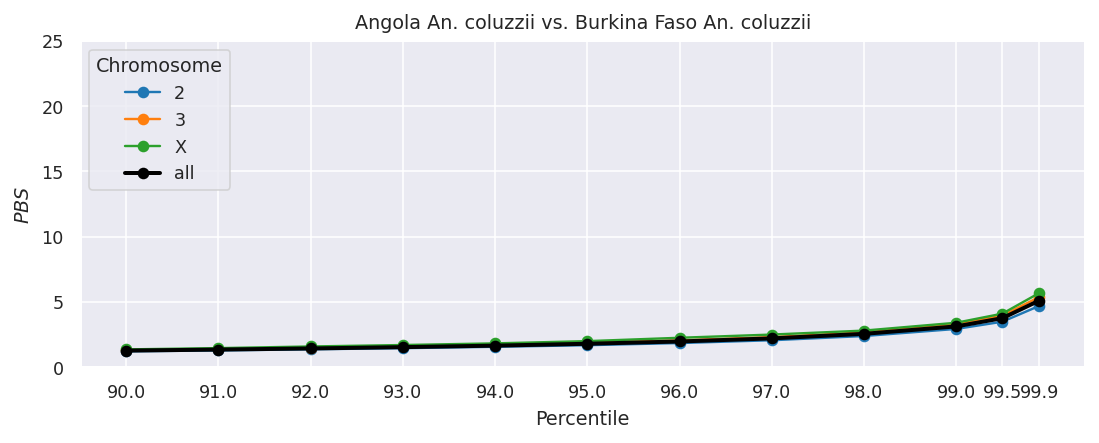

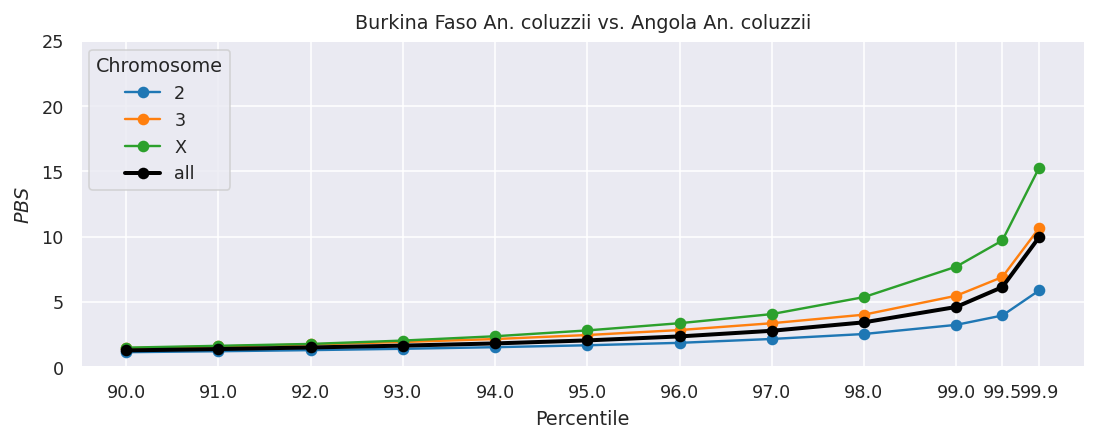

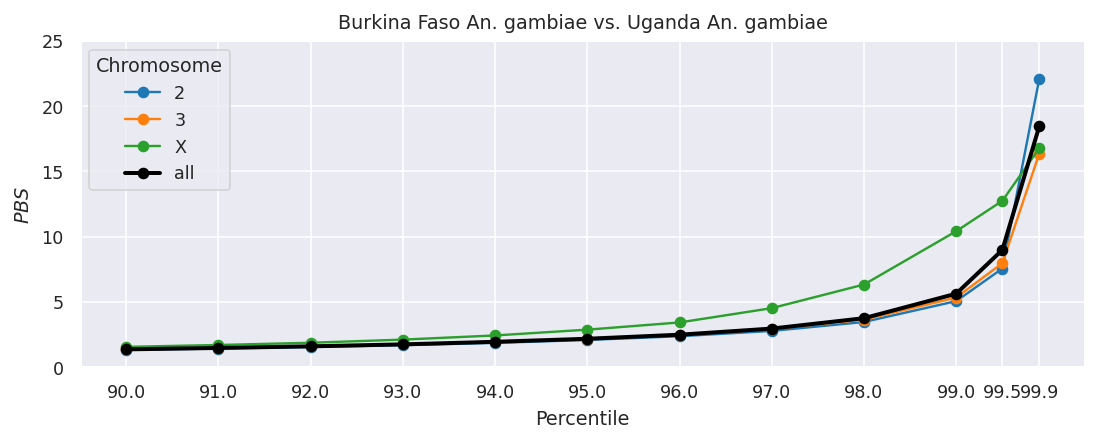

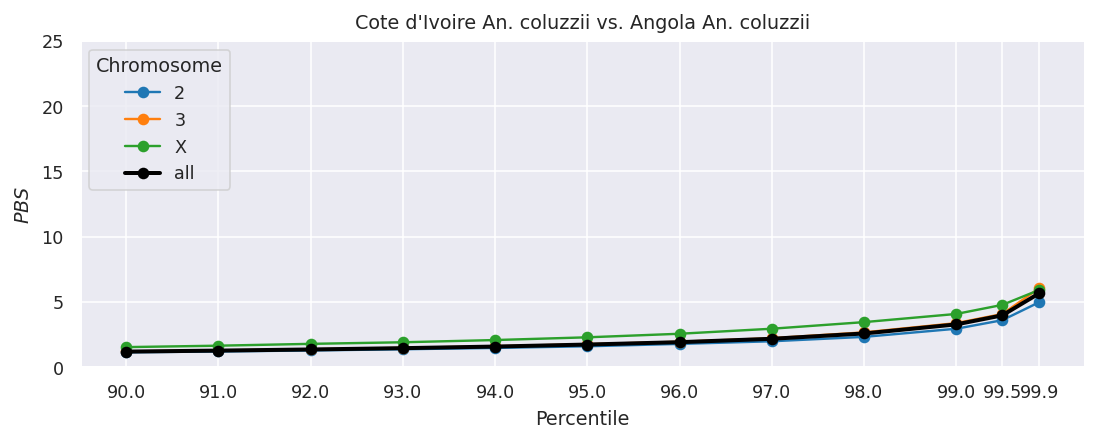

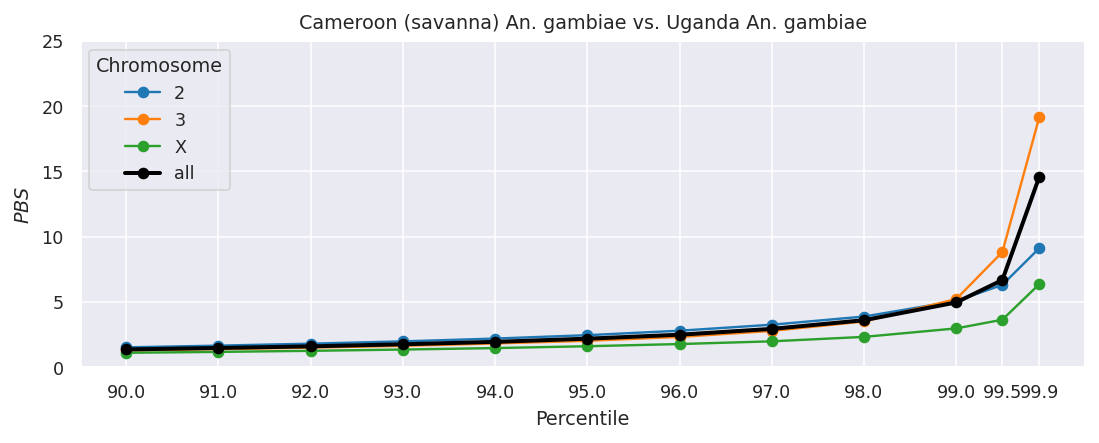

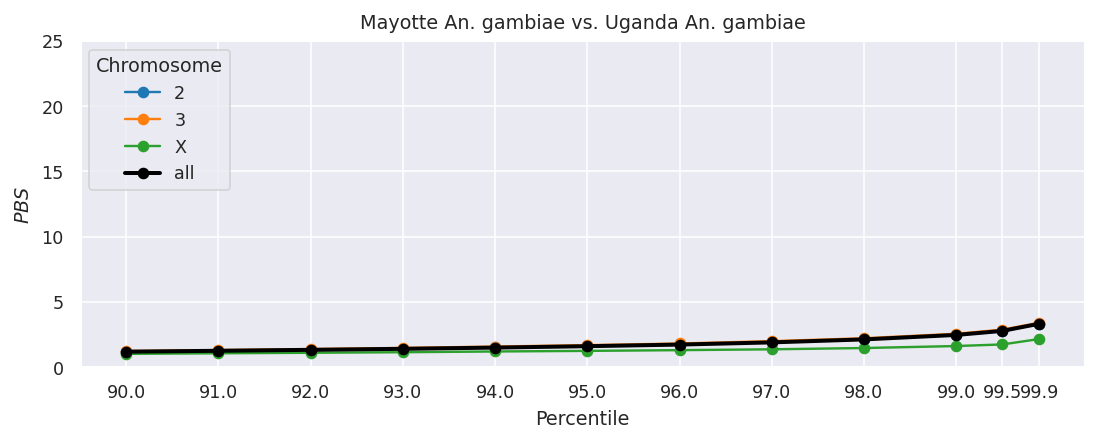

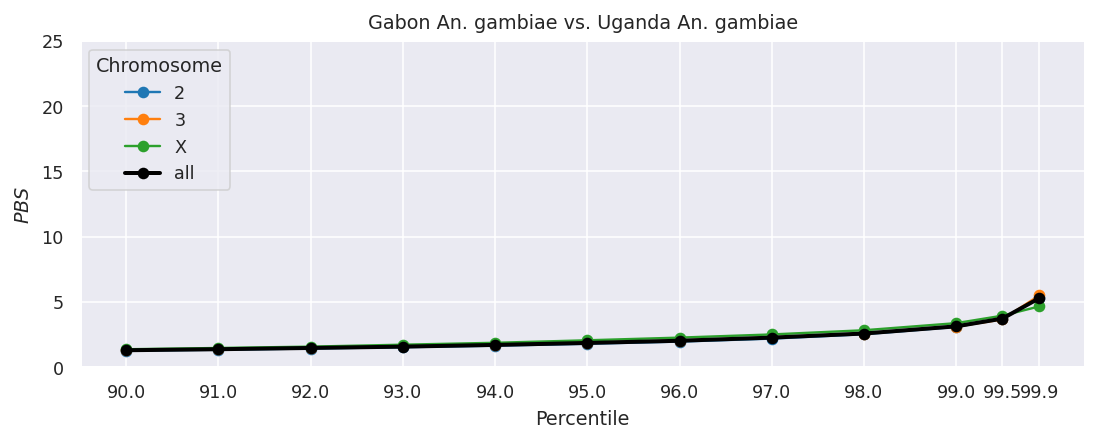

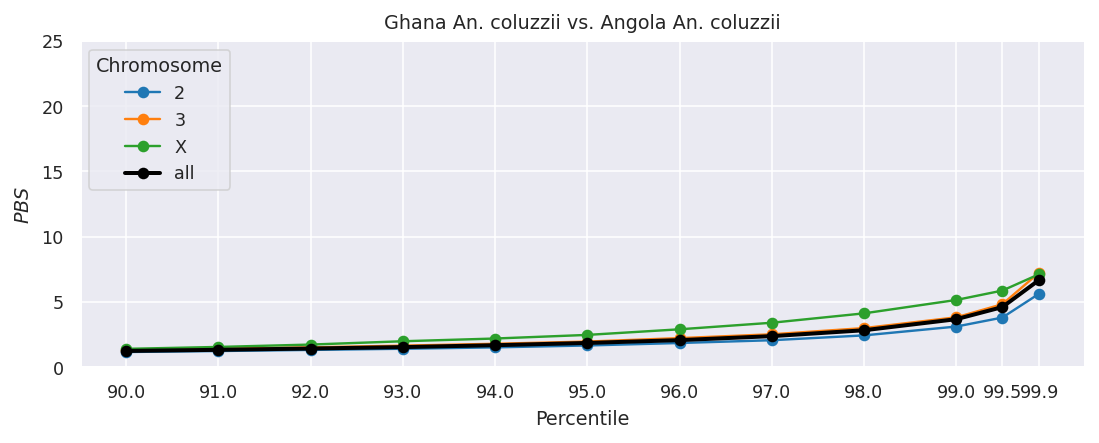

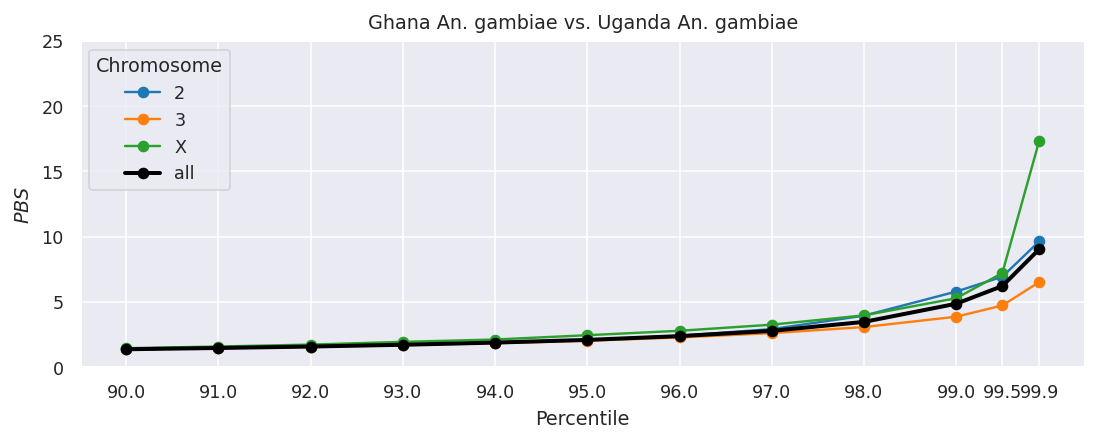

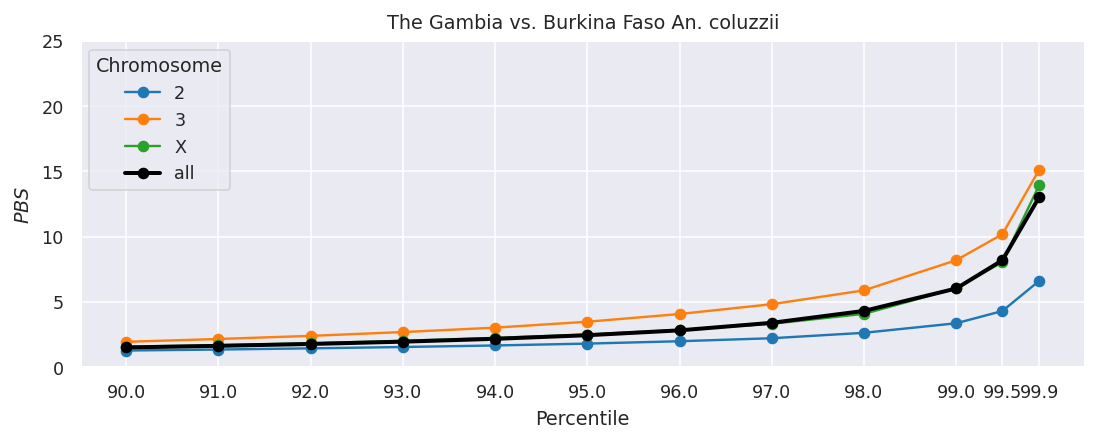

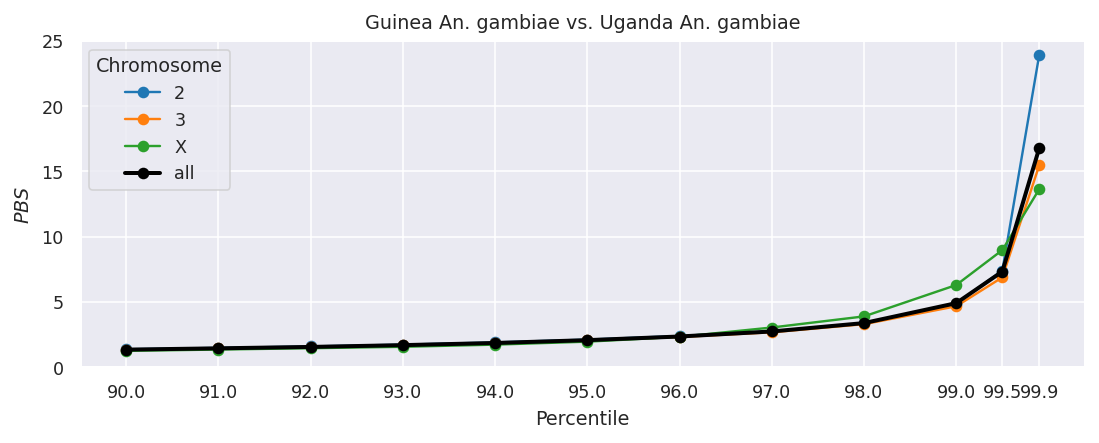

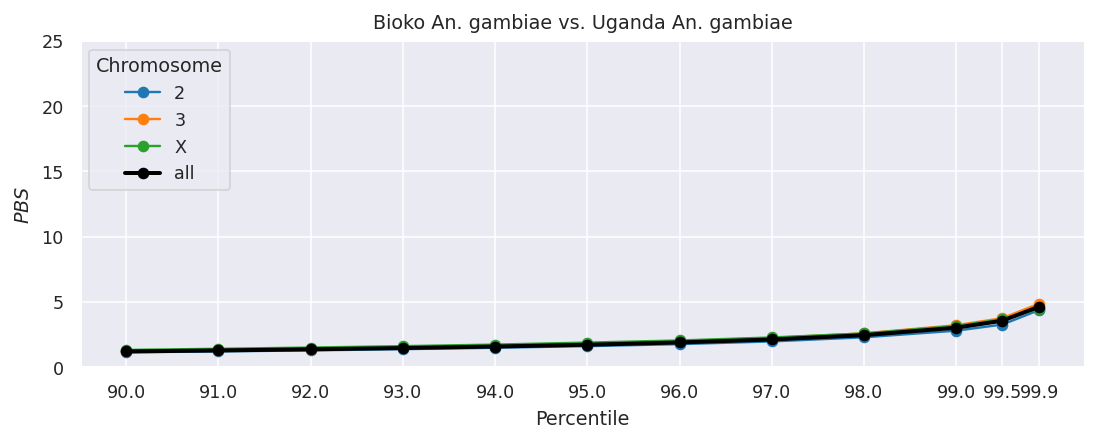

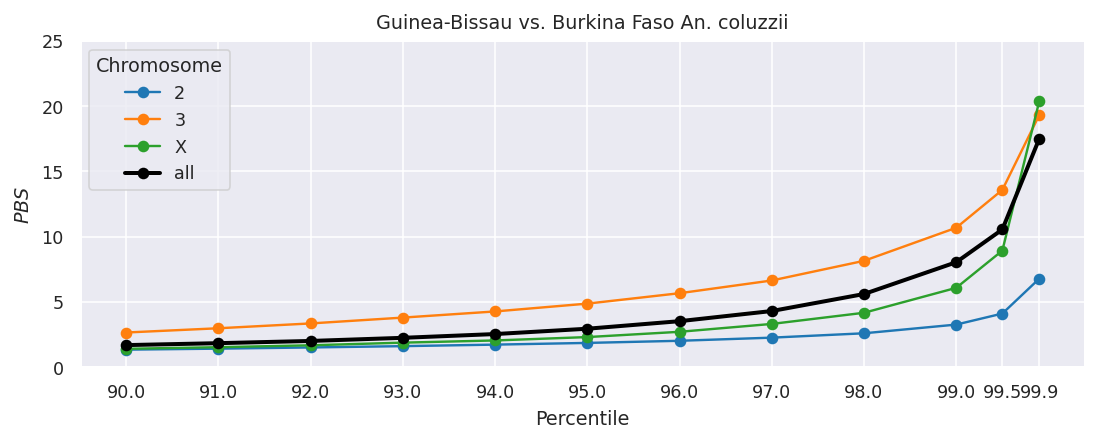

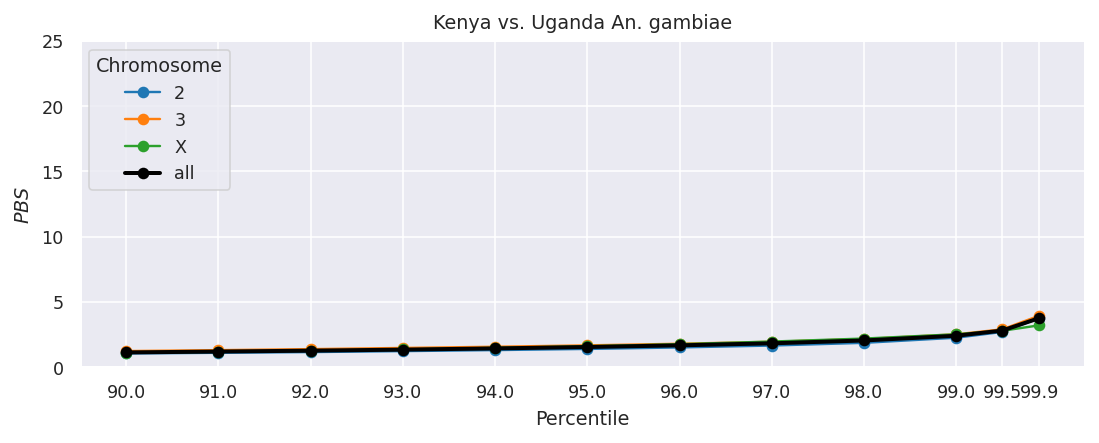

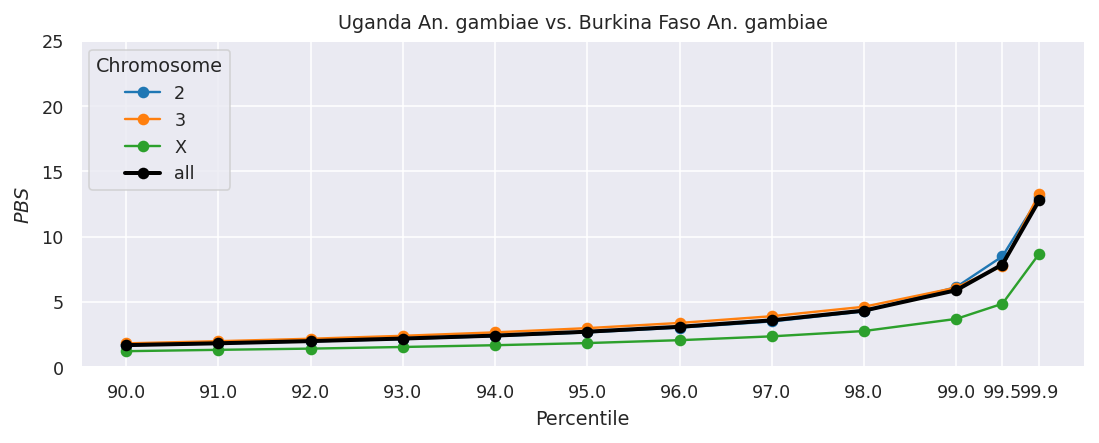

In [4]:
for pop in pop_defs:
    plot_signal_percentiles(pop)

In [5]:
@functools.lru_cache(maxsize=None)
def get_signal_percentile(pop1, pop2, pop3, q, window_size, window_step):
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, _, signal = load_pbs_gwss(
            pop1, pop2, pop3, chromosome, window_size=window_size, window_step=window_step
        )
        all_vals.append(signal)
    signal = np.concatenate(all_vals)
    return np.percentile(signal, q)
    

In [6]:
get_signal_percentile('bf_gam', 'ug_gam', 'gq_gam', 99, 500, 250)

5.6202264402326705

### Plotting and analysis functions

In [7]:
def plot_signal(pop, chromosome, center, flank, ax=None, markersize=2, 
                window_size=500, window_step=250,
                legend=False, label=True, ymax=None, genetic_distance=False,
                percentiles=[98], has_peak_n=20,
                has_peak_dist=.2, median_filter=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
    pop2, pop3 = pbs_partners[pop]
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
    else:
        raise ValueError

    # load gwss data
    windows, gwindows, _, signal = load_pbs_gwss(
        pop, pop2, pop3, chromosome, window_size=window_size, window_step=window_step
    )
    if median_filter:
        signal = scipy.ndimage.median_filter(signal, size=median_filter, mode='wrap')
    p = windows.mean(axis=1)/1e6
    gp = gwindows.mean(axis=1)
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p

    # plot percentiles
    qvals = []
    for q in percentiles:
        v = get_signal_percentile(pop, pop2, pop3, q, window_size=window_size, 
                                     window_step=window_step)
        qvals.append(v)
        ax.axhline(v, color='k', linestyle='--', lw=.5)
        ax.annotate(f'$P_{{{q}}}$', xy=(xlim[1], v), xytext=(2, 0), xycoords='data', 
                    textcoords='offset points', ha='left', va='center', fontsize=8)
    
    # plot gwss data
    palette = sns.color_palette()
    ax.plot(x, signal, marker='o', linestyle=' ', 
            markersize=markersize, color=palette[4])

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        ymax = max(20, 1.1*max(qvals), 1.1*np.max(signal[loc_xlim]))
    ax.set_ylim(0, ymax)
    ax.set_ylabel('$PBS$')
            
    # statistics
    has_peak = False
    try:
        loc_peak_test = allel.SortedIndex(p).locate_range(center-has_peak_dist, center+has_peak_dist)
        has_peak = np.count_nonzero(signal[loc_peak_test] > qvals[-1]) > has_peak_n
    except KeyError:
        pass
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-.5, center+.5)
        peak_value = np.max(signal[loc_region])
        peak_pos = p[loc_region][np.argmax(signal[loc_region])] - center
        statistics = dict(
            pop=pop,
            peak_value=peak_value,
            peak_pos=peak_pos
        )
    else:
        statistics = dict(
            pop=pop,
            peak_value=np.nan,
            peak_pos=np.nan,
        )
    
    if label:
        pop_label = (
            pop_defs[pop]['label']
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        pop2_label = (
            pop_defs[pop2]['label']
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        pop3_label = (
            pop_defs[pop3]['label']
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        if has_peak:
            annotation = (
                f"{pop_label}\n"
                f"vs. {pop2_label}, {pop3_label}\n"
                f"$PBS_{{peak}}={peak_value:.1f}$\n"
                f"$pos(PBS_{{peak}})={peak_pos*1e3:+.1f}$ kbp"
            )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xytext=(8, -8), 
                    xycoords='axes fraction', textcoords='offset points', 
                    fontsize=8, va='top', ha='left', backgroundcolor='white')
    
    return statistics

{'pop': 'bf_gam',
 'peak_value': 37.46545755117652,
 'peak_pos': 0.23428300000000135}

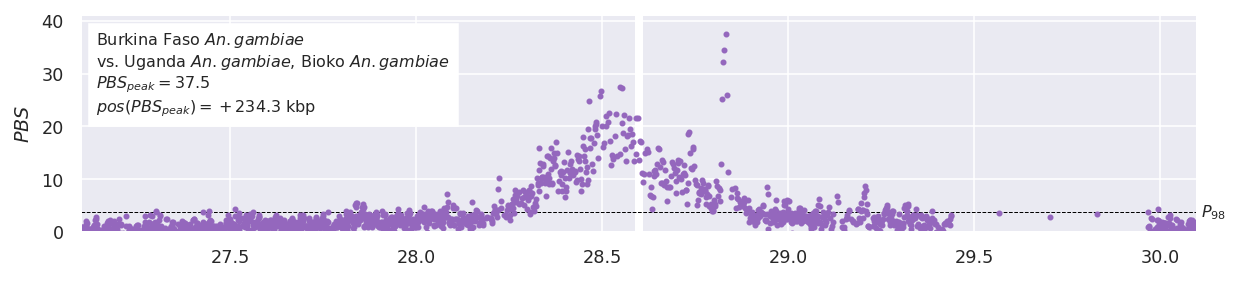

In [8]:
plot_signal('bf_gam', gste2.chromosome, gste2.chromosome_center/1e6, flank=1.5)

{'pop': 'bf_gam',
 'peak_value': 20.030622948715678,
 'peak_pos': -0.10806150000000159}

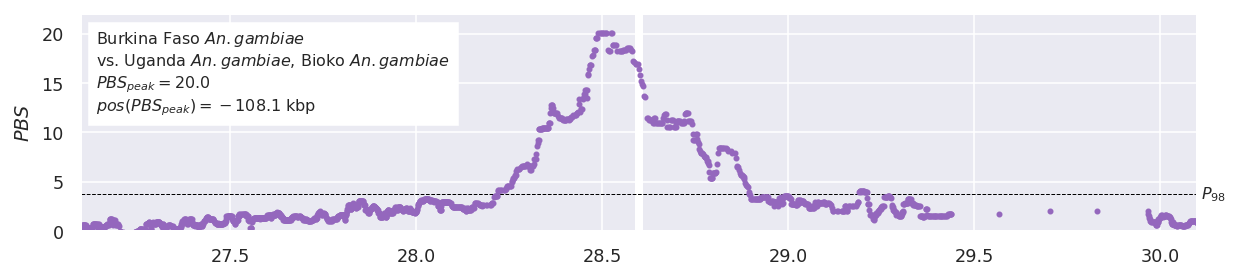

In [9]:
plot_signal('bf_gam', gste2.chromosome, gste2.chromosome_center/1e6, flank=1.5, median_filter=20)

In [10]:
all_stats = dict()


def analyse_gene(gene, flank=1.5, genetic_distance=False, has_peak_n=20, has_peak_dist=.2):
    
    # first pass, plot all populations
    df_stats = fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'], track_height=2, 
        genetic_distance=genetic_distance,
        plot_kwargs=dict(ymax=50, has_peak_n=has_peak_n, has_peak_dist=has_peak_dist),
        tracks=(
            (plot_signal, dict(pop='bf_gam')),
            (plot_signal, dict(pop='gn_gam')),
            (plot_signal, dict(pop='gh_gam')),
            (plot_signal, dict(pop='cm_sav_gam')),
            (plot_signal, dict(pop='ug_gam')),
            (plot_signal, dict(pop='ga_gam')),
            (plot_signal, dict(pop='gq_gam')),
            (plot_signal, dict(pop='fr_gam')),
            (plot_signal, dict(pop='bf_col')),
            (plot_signal, dict(pop='ci_col')),
            (plot_signal, dict(pop='gh_col')),
            (plot_signal, dict(pop='ao_col')),
            (plot_signal, dict(pop='gw')),
            (plot_signal, dict(pop='gm')),
            (plot_signal, dict(pop='ke')),
        ),
    )
    plt.show()
    plt.close()
    
    # store stats
    all_stats[gene['Name'].lower()] = df_stats
    
    # find pops with peak
    peak_pops = df_stats[~df_stats.peak_value.isna()]['pop'].values
    
    if len(peak_pops) < 6:
        track_height = 2.3
    else:
        track_height = None

    # second pass, plot only pops with a peak
    fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'],
        genetic_distance=genetic_distance,
        track_height=track_height,
        plot_kwargs=dict(has_peak_n=has_peak_n, has_peak_dist=has_peak_dist),
        tracks=[(plot_signal, dict(pop=pop)) for pop in peak_pops],
        savefig=here() / f"artwork/locus_{gene['Name'].lower()}_pbs_{'g' if genetic_distance else 'p'}dist.png"
    )  
    plt.show()
    plt.close()
    

## *Gste2*

In [11]:
gste2

seqid                                                               3R
source                                                       VEuPathDB
type                                                              gene
start                                                         28597652
end                                                           28598640
score                                                               -1
strand                                                               -
phase                                                               -1
description          glutathione S-transferase epsilon class 2 [Sou...
chromosome                                                           3
chromosome_start                                              28597652
chromosome_end                                                28598640
chromosome_center                                          2.85981e+07
Name                                                             Gste2
Name: 

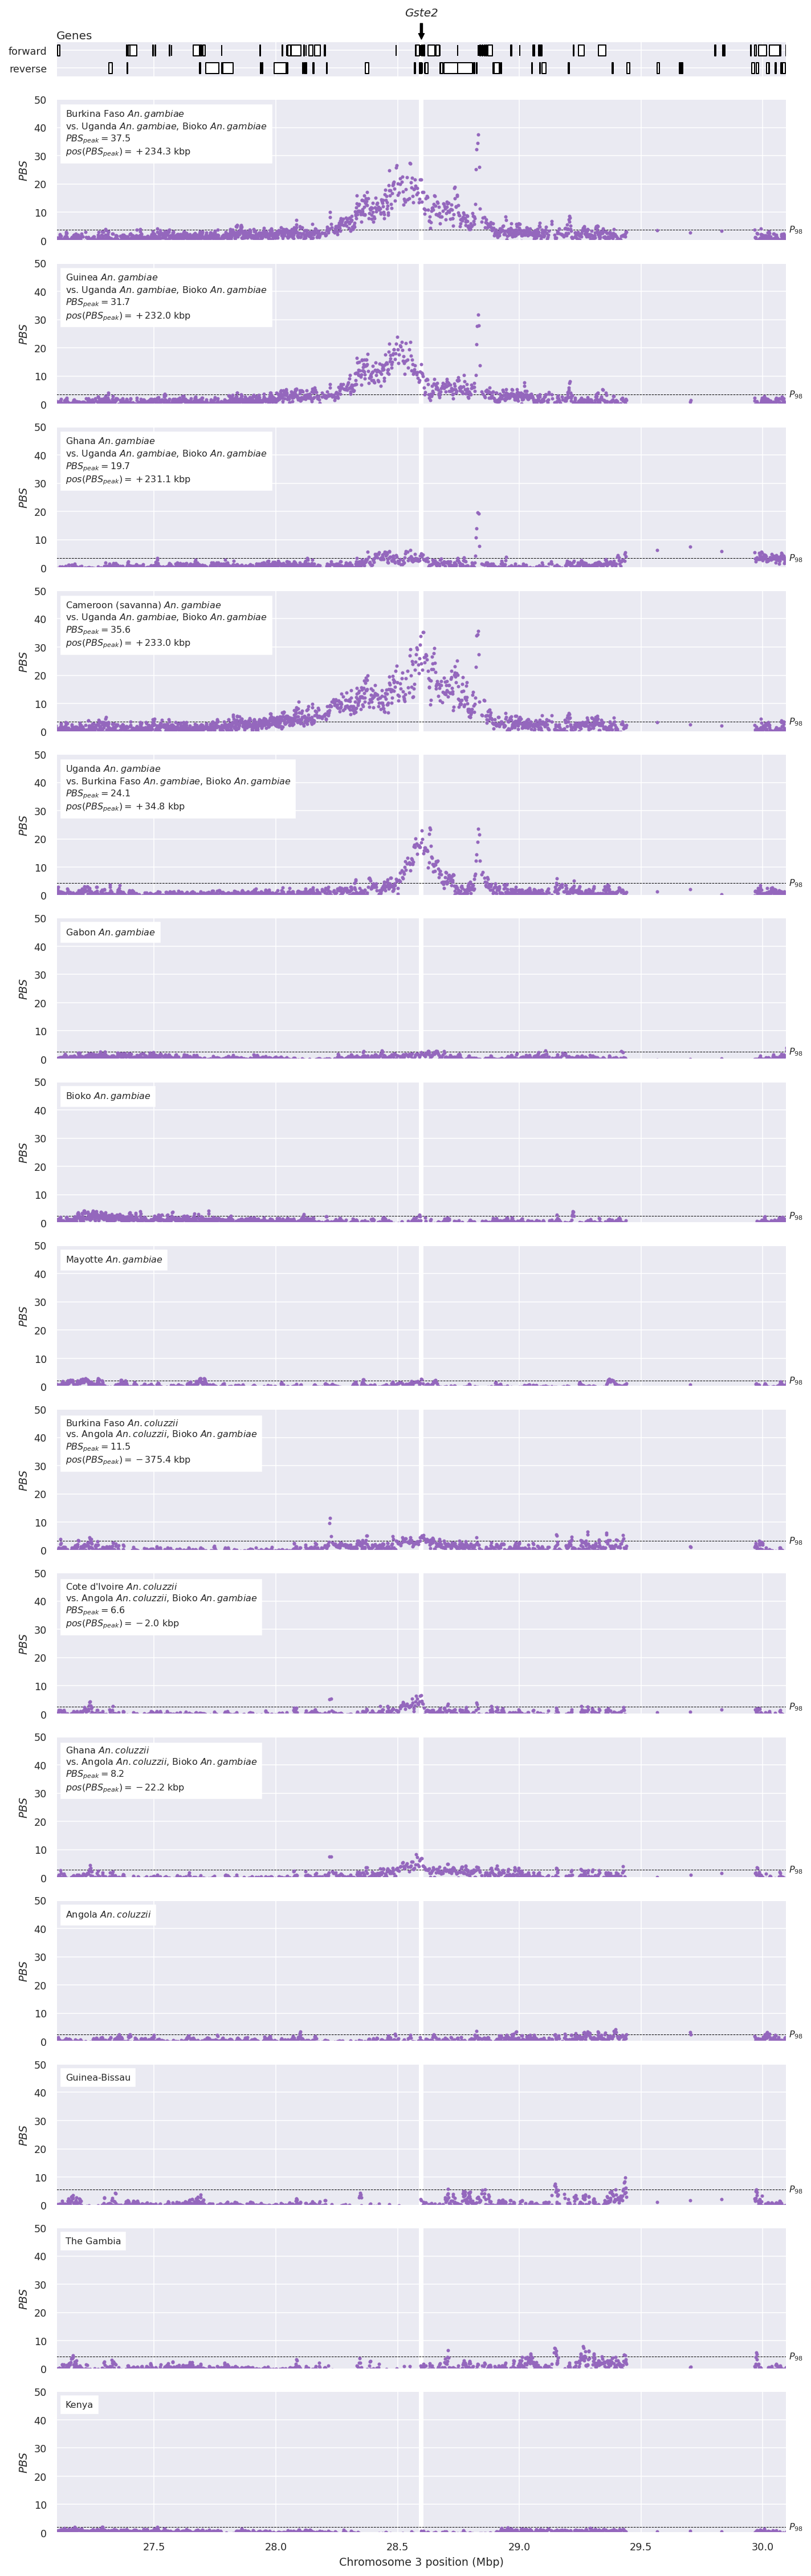

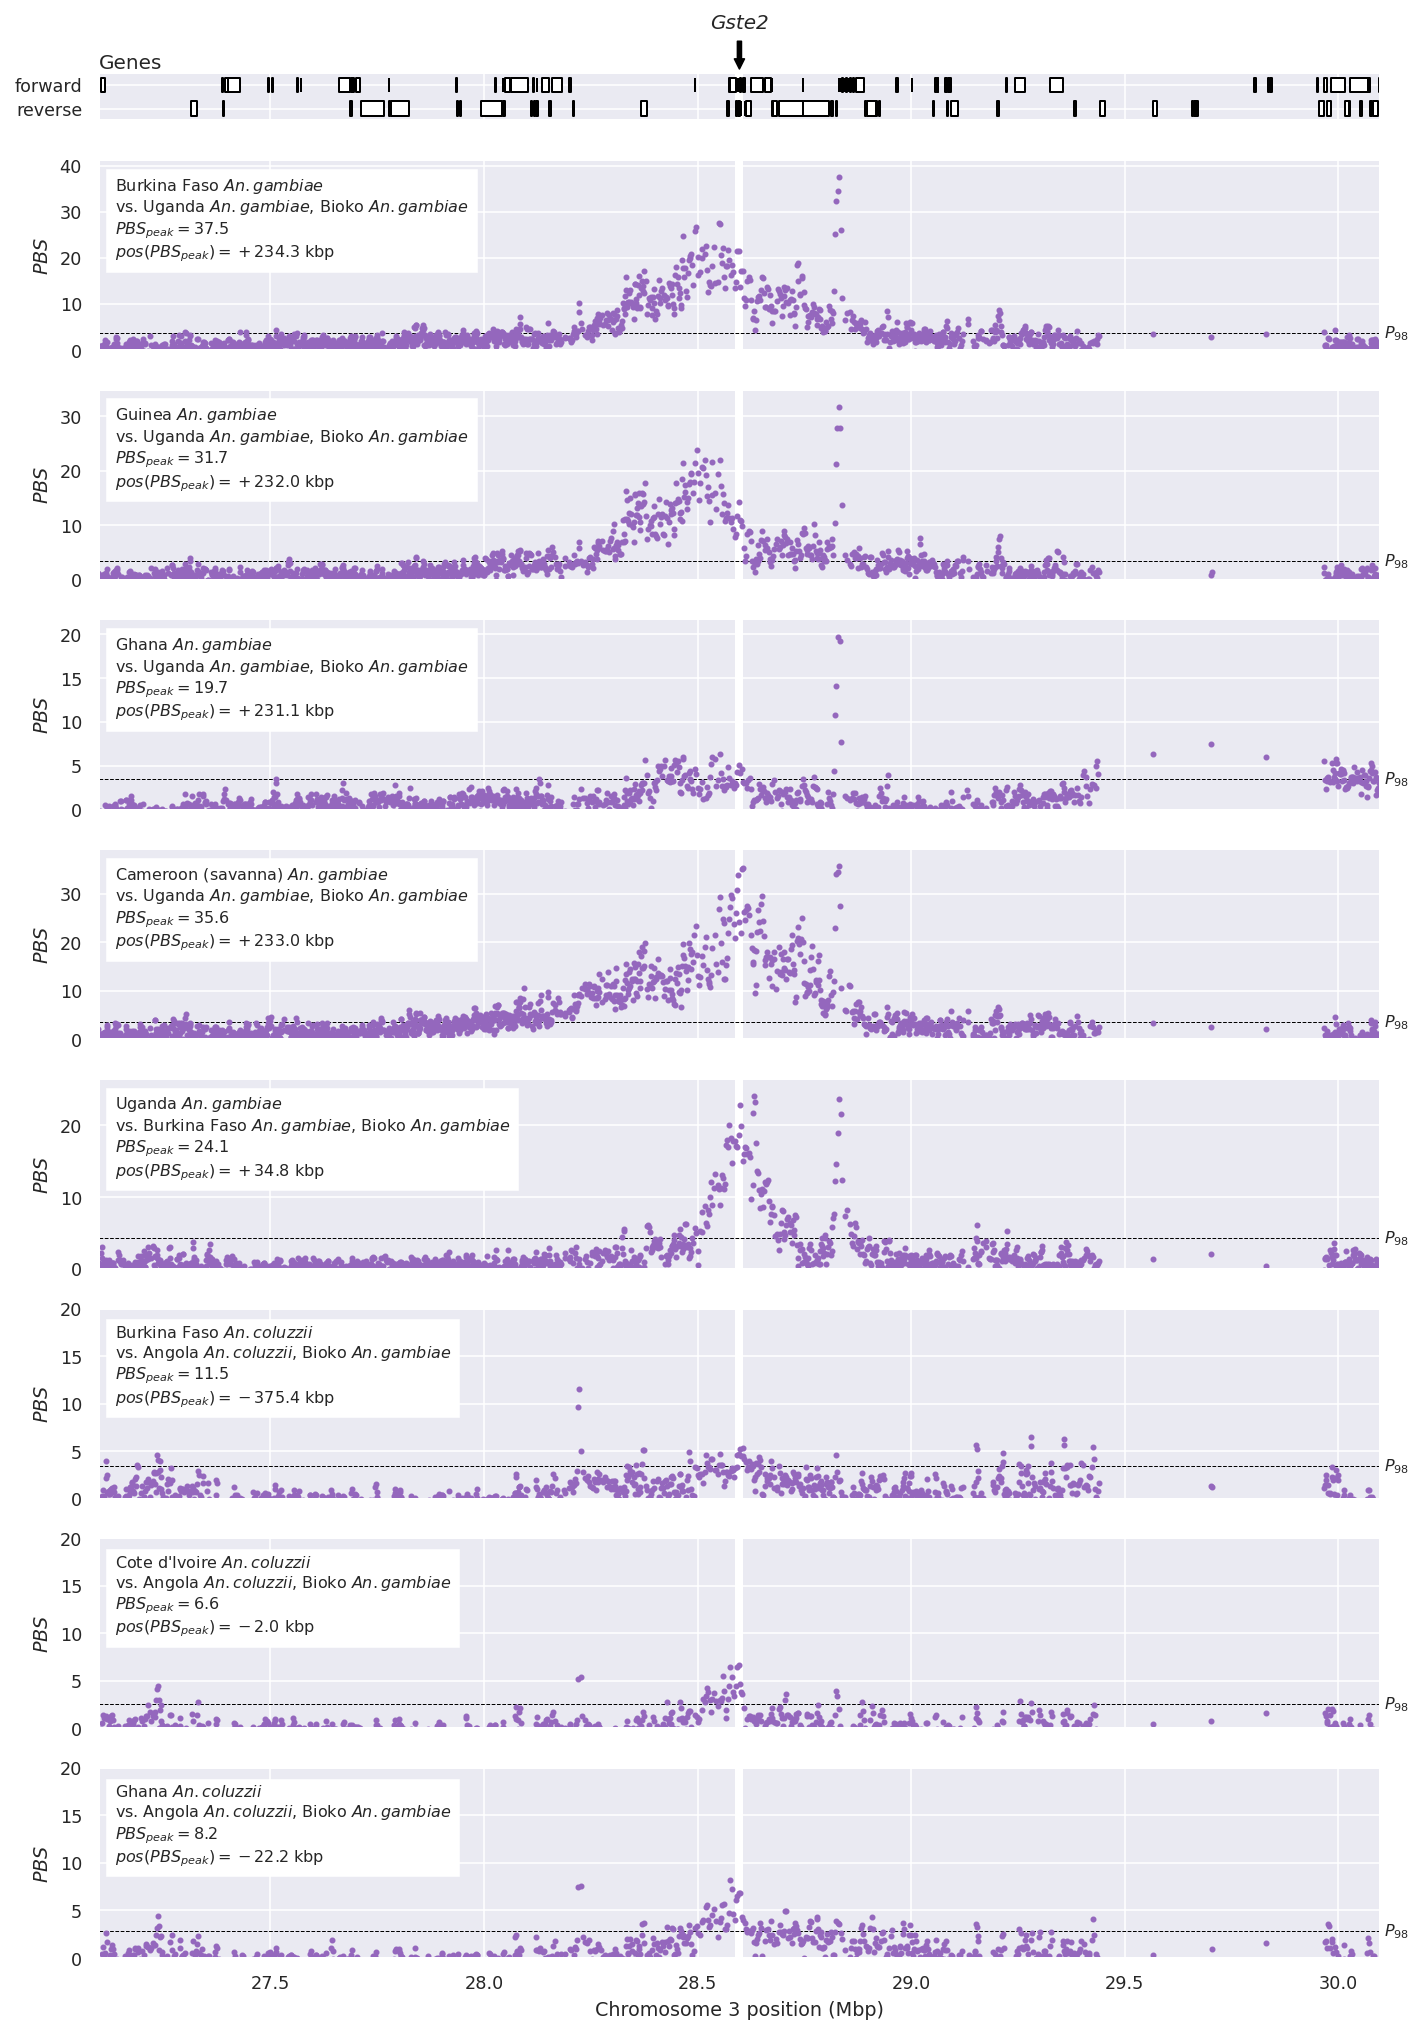

In [12]:
analyse_gene(gste2)

## *Cyp6p3*

In [13]:
cyp6p3

seqid                                                              2R
source                                                      VEuPathDB
type                                                             gene
start                                                        28491415
end                                                          28493141
score                                                              -1
strand                                                              -
phase                                                              -1
description          cytochrome P450 [Source:VB Community Annotation]
chromosome                                                          2
chromosome_start                                             28491415
chromosome_end                                               28493141
chromosome_center                                         2.84923e+07
Name                                                           Cyp6p3
Name: AGAP002865, dt

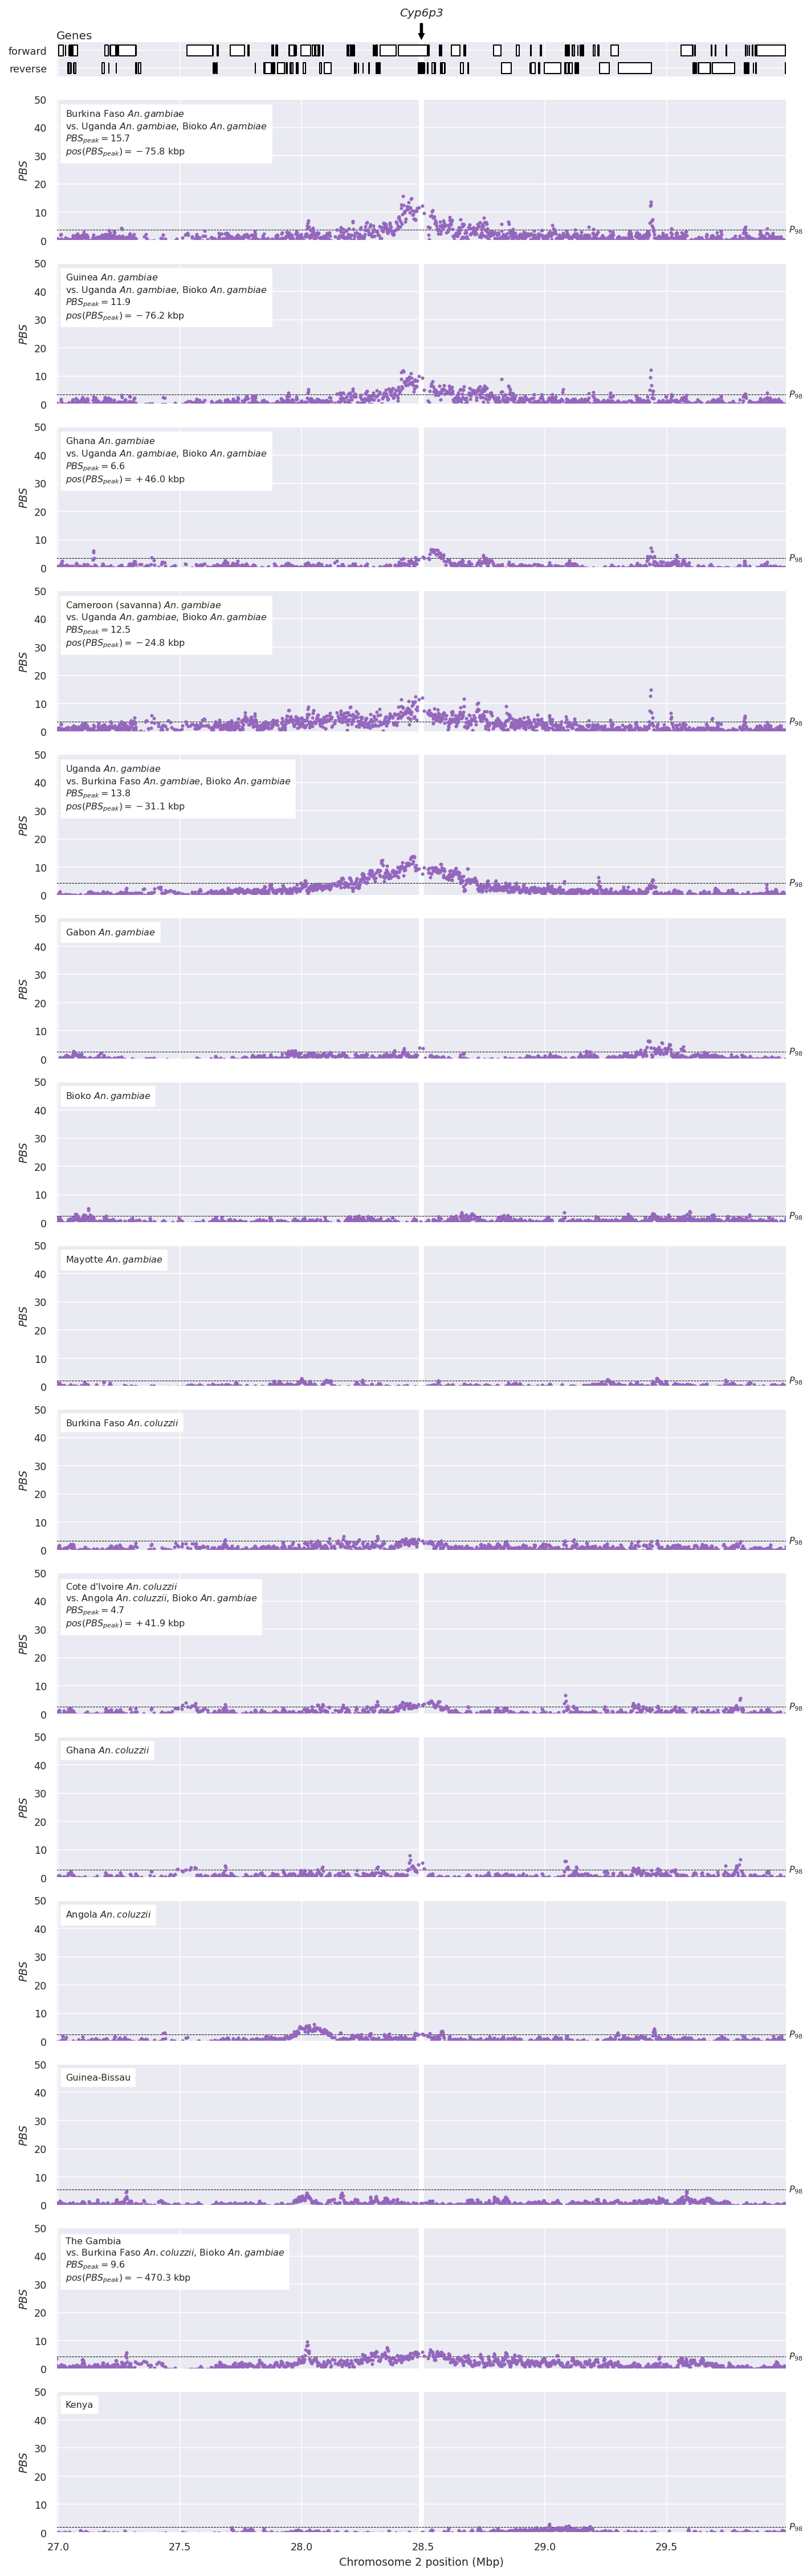

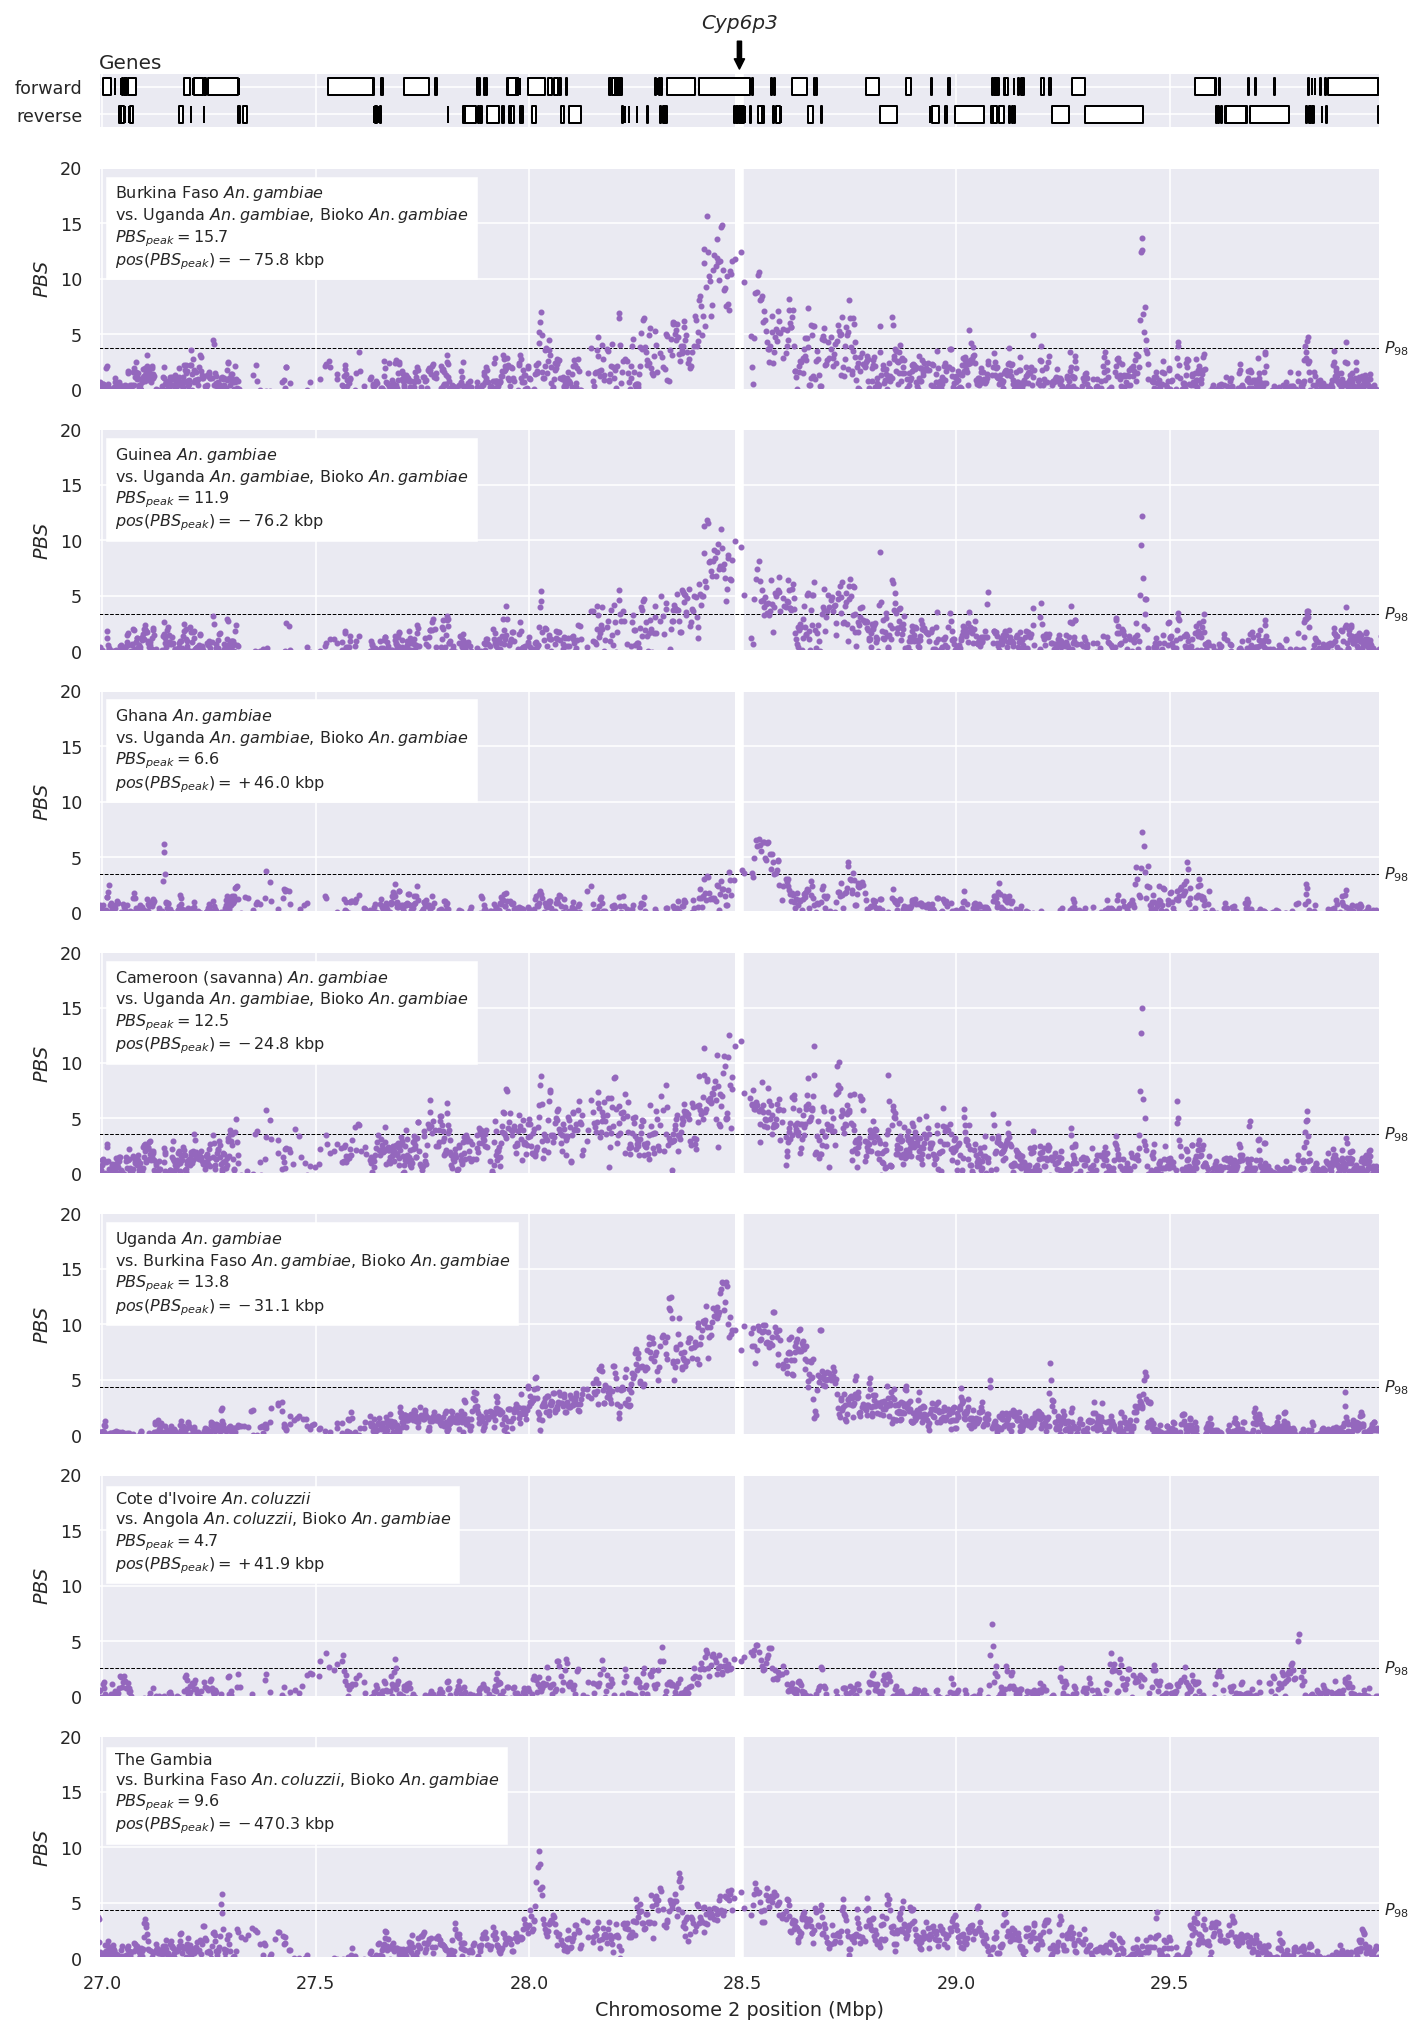

In [14]:
analyse_gene(cyp6p3)

## *Cyp9k1*

In [15]:
cyp9k1

seqid                                                               X
source                                                      VEuPathDB
type                                                             gene
start                                                        15240572
end                                                          15242864
score                                                              -1
strand                                                              -
phase                                                              -1
description          cytochrome P450 [Source:VB Community Annotation]
chromosome                                                          X
chromosome_start                                             15240572
chromosome_end                                               15242864
chromosome_center                                         1.52417e+07
Name                                                           Cyp9k1
Name: AGAP000818, dt

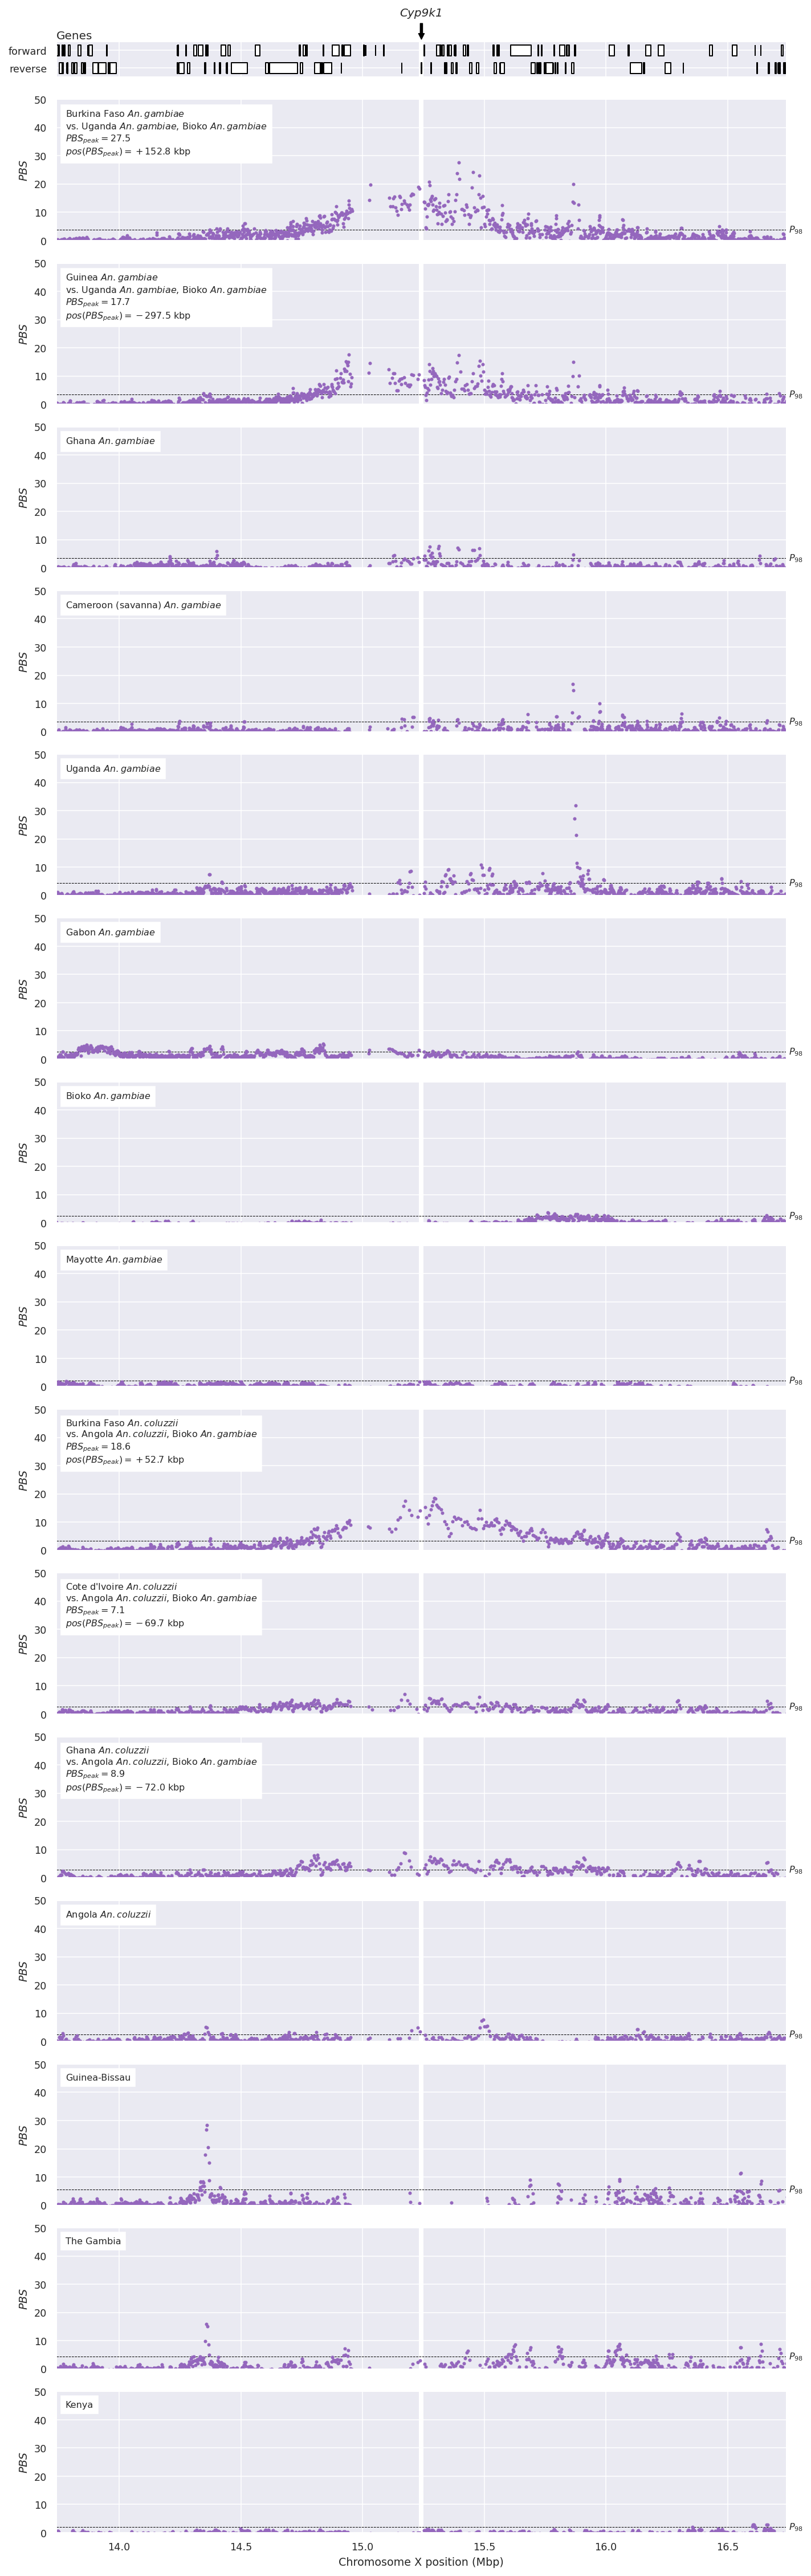

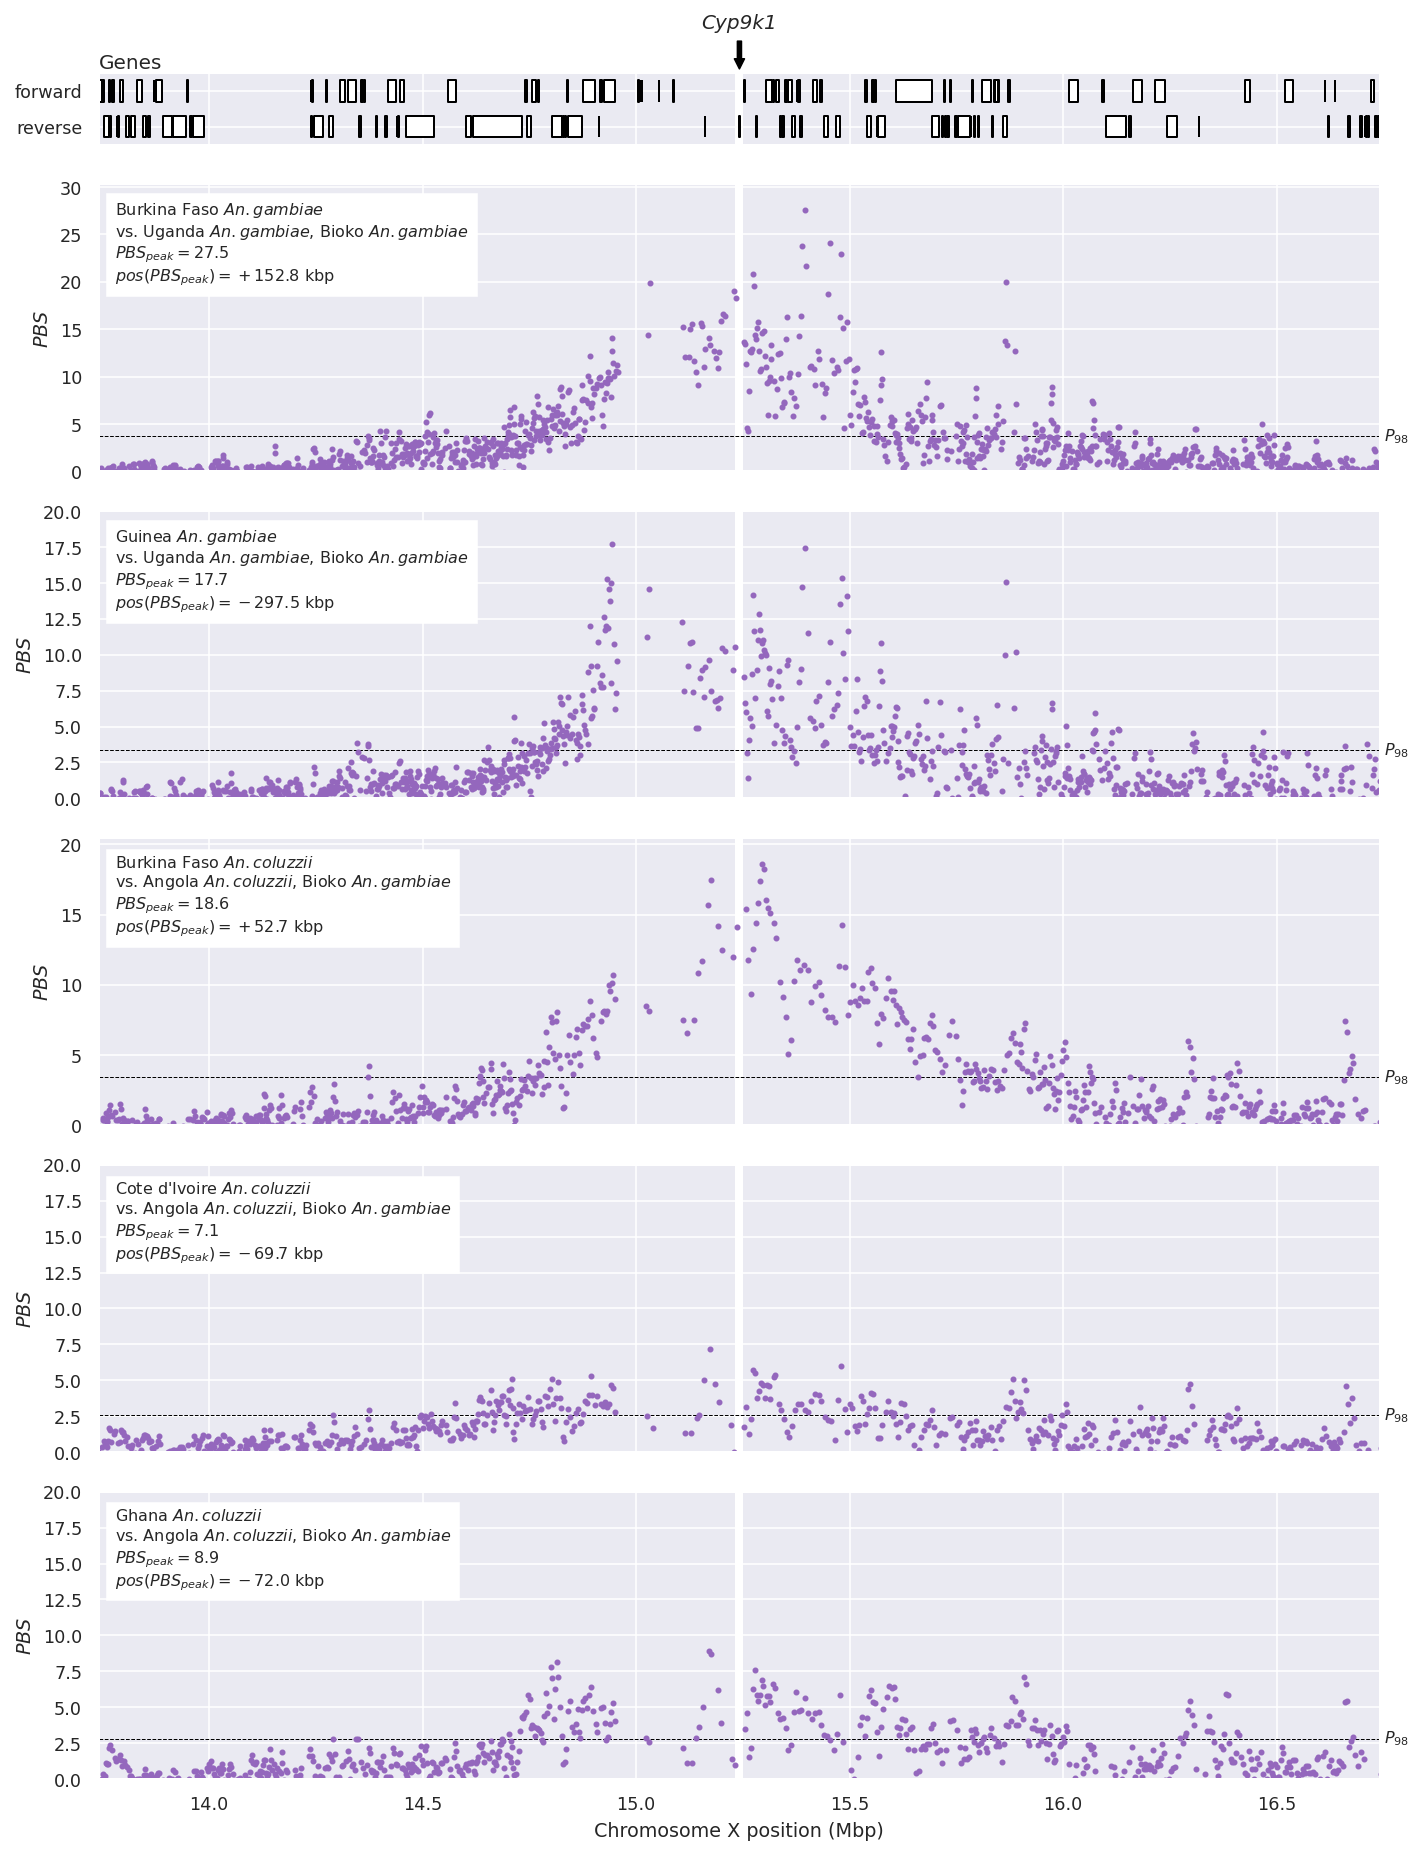

In [16]:
analyse_gene(cyp9k1)

## *Vgsc*

In [17]:
vgsc

seqid                                                               2L
source                                                       VEuPathDB
type                                                              gene
start                                                          2358158
end                                                            2431617
score                                                               -1
strand                                                               +
phase                                                               -1
description          voltage-gated sodium channel [Source:VB Commun...
chromosome                                                           2
chromosome_start                                              63903263
chromosome_end                                                63976722
chromosome_center                                            6.394e+07
Name                                                              Vgsc
Name: 

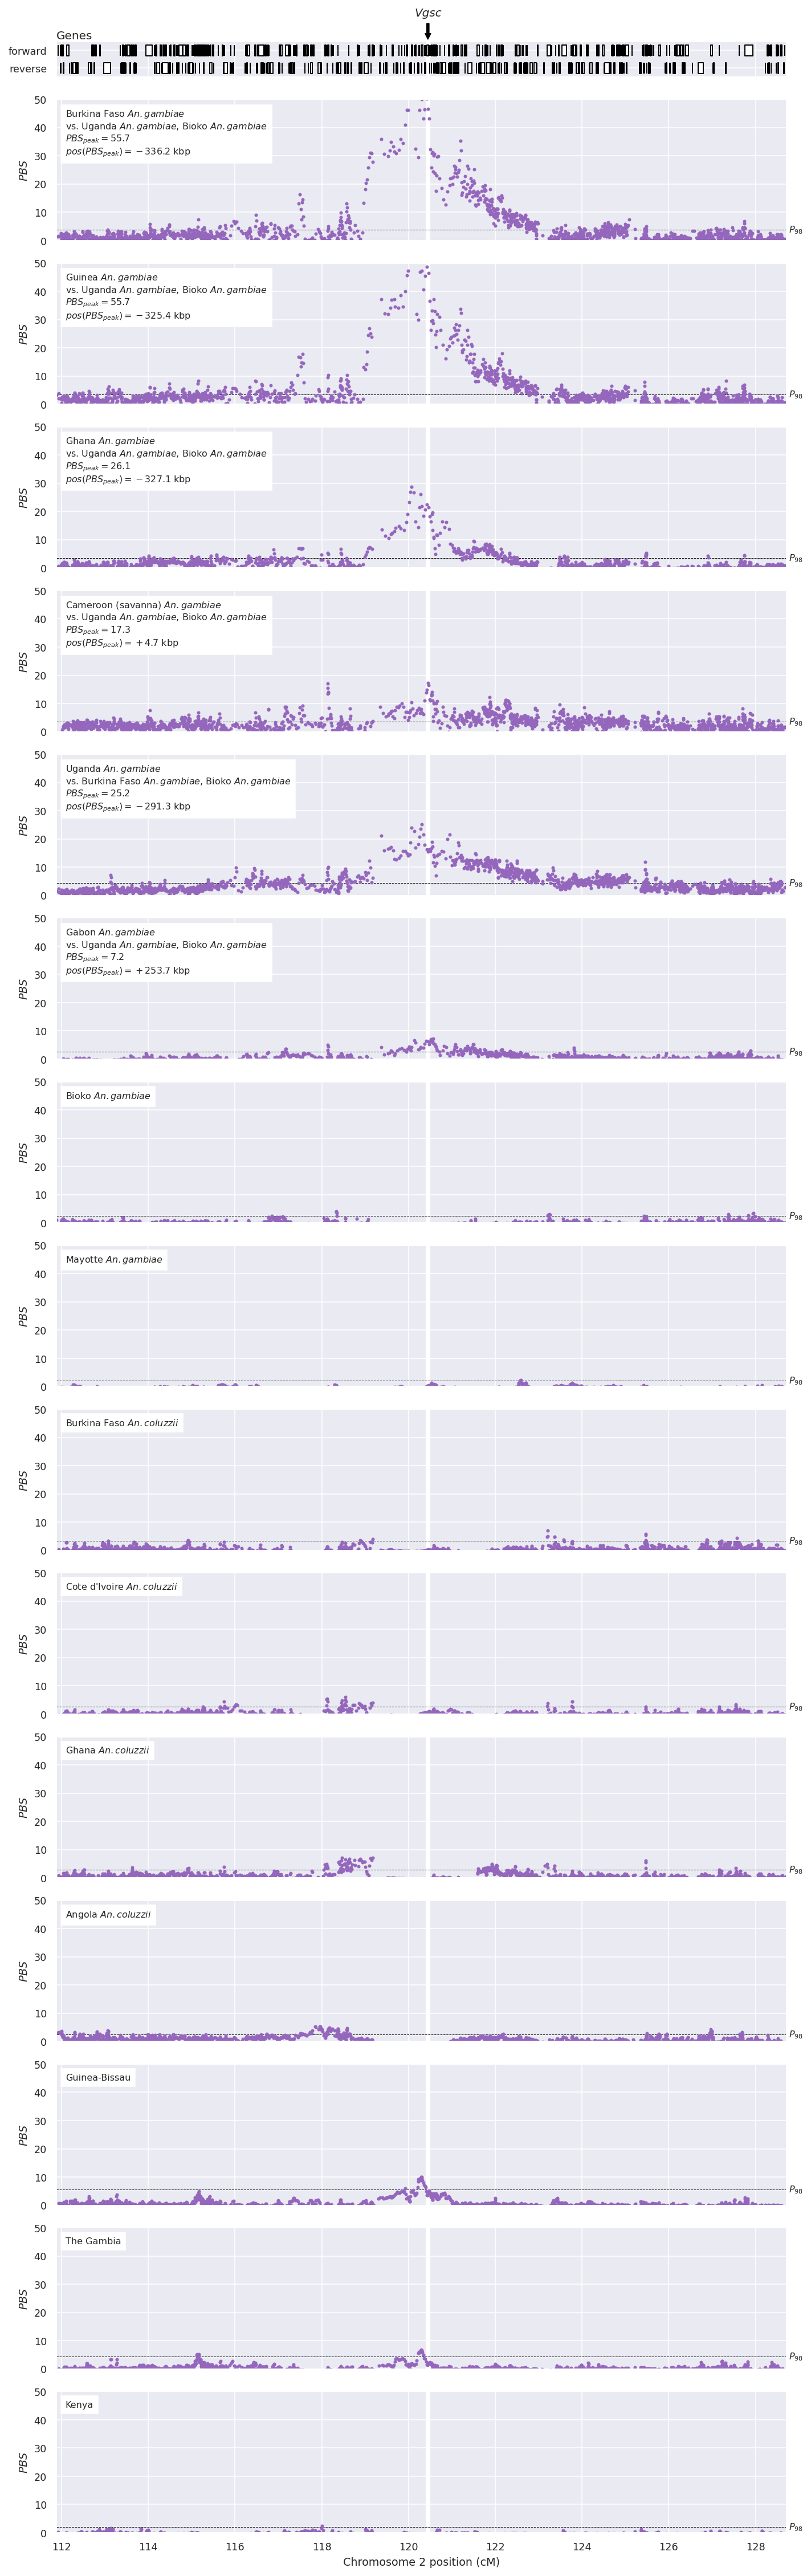

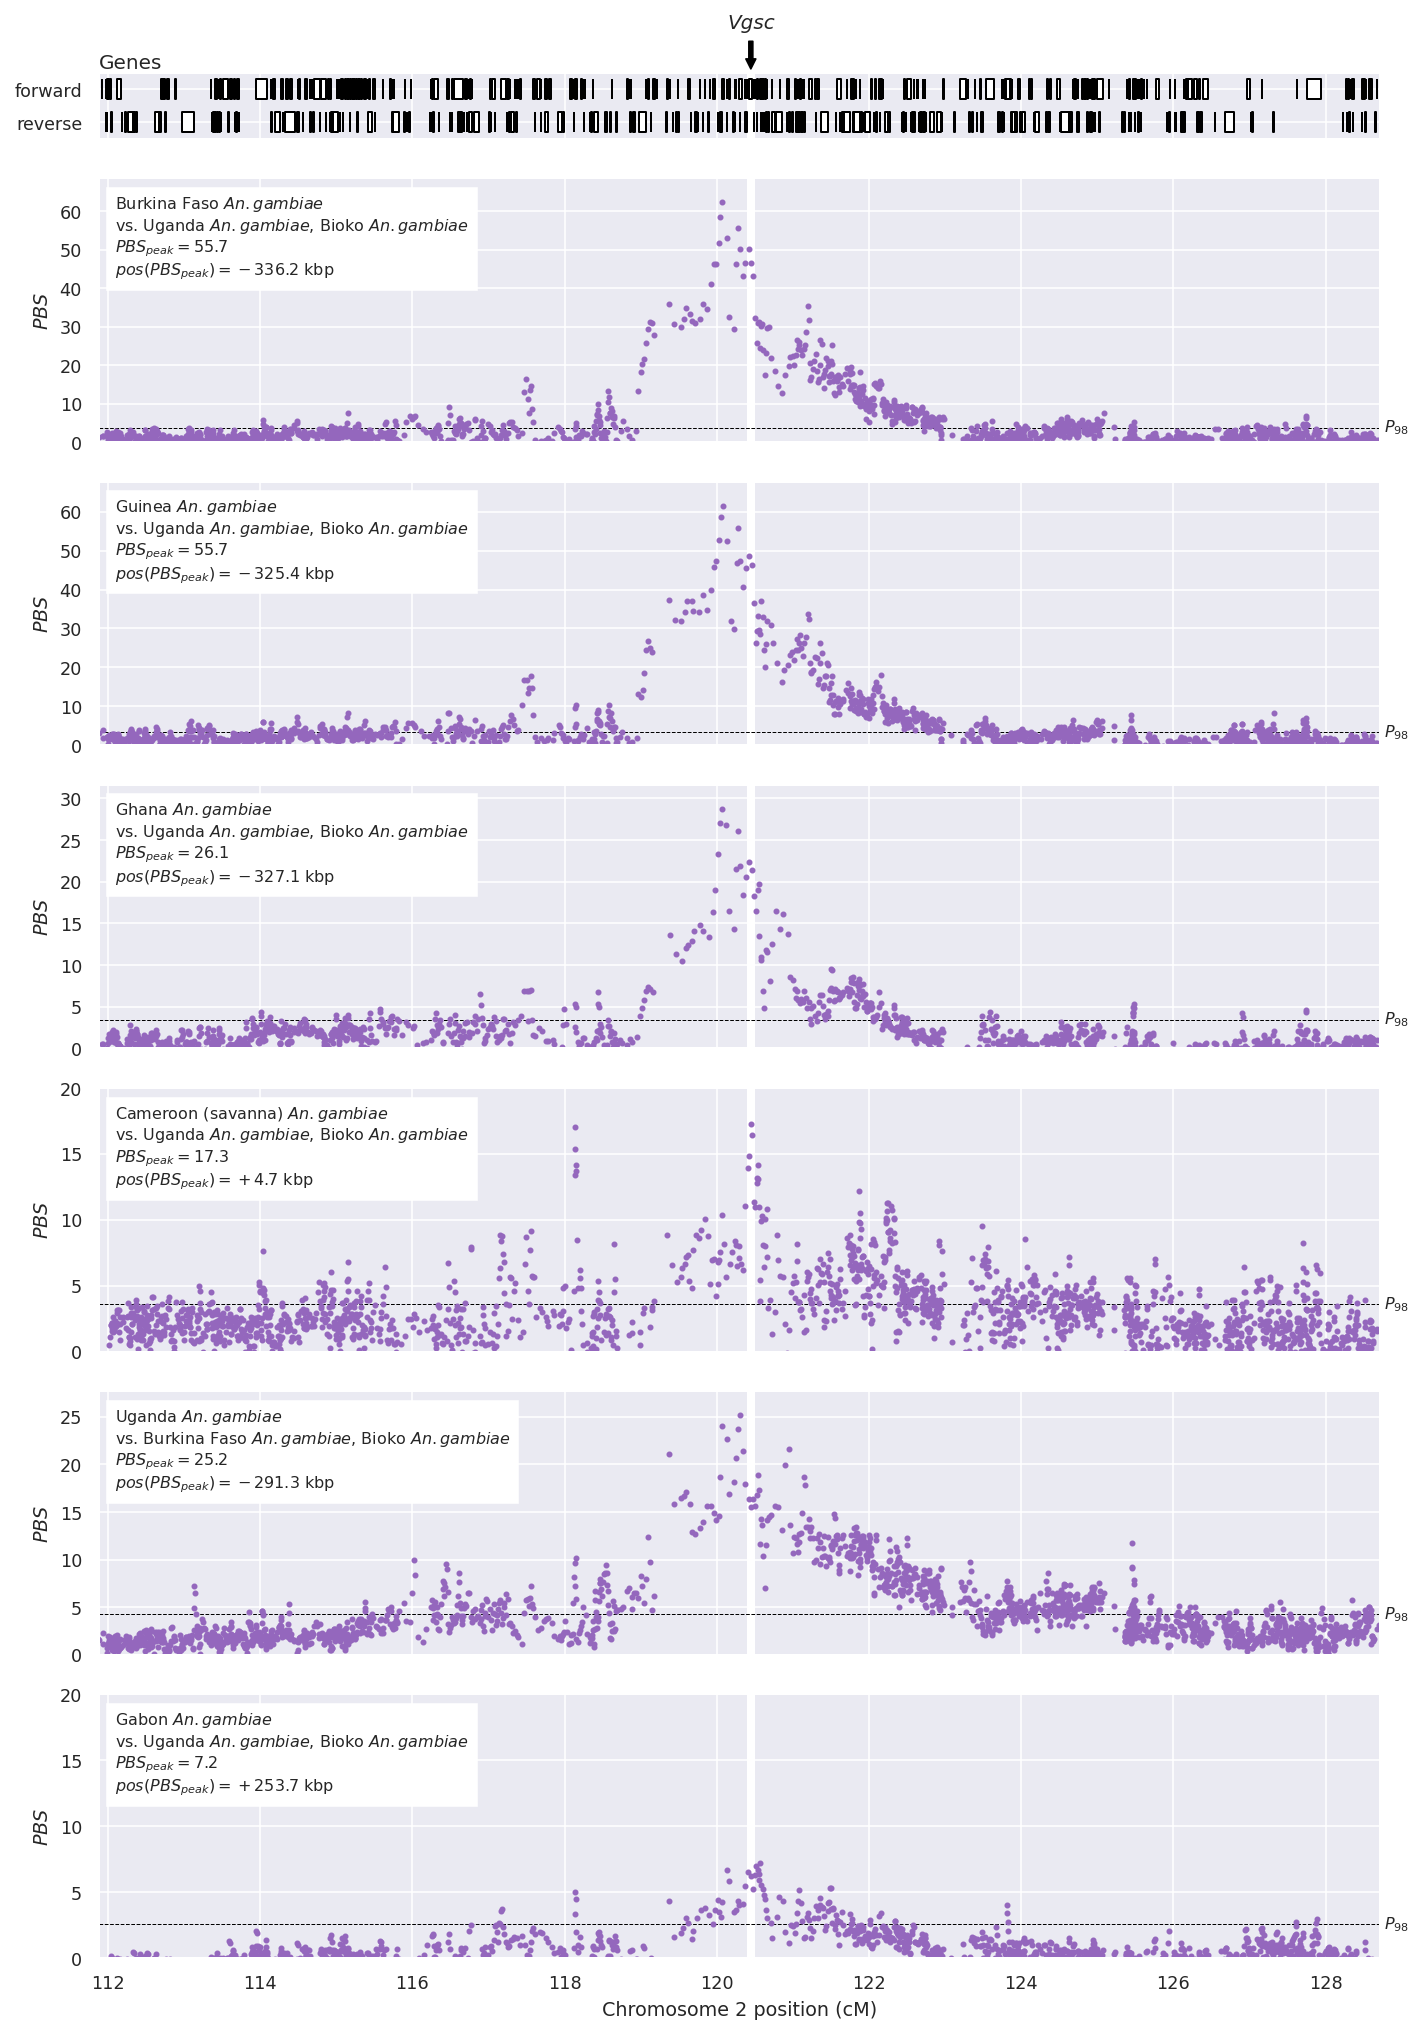

In [18]:
analyse_gene(vgsc, flank=(8, 5), genetic_distance=True, has_peak_dist=.5)

## *Gaba*

In [19]:
gaba

seqid                                                               2L
source                                                       VEuPathDB
type                                                              gene
start                                                         25363652
end                                                           25434556
score                                                               -1
strand                                                               +
phase                                                               -1
description          GABA-gated chloride channel subunit [Source:VB...
chromosome                                                           2
chromosome_start                                              86908757
chromosome_end                                                86979661
chromosome_center                                          8.69442e+07
Name                                                              Gaba
Name: 

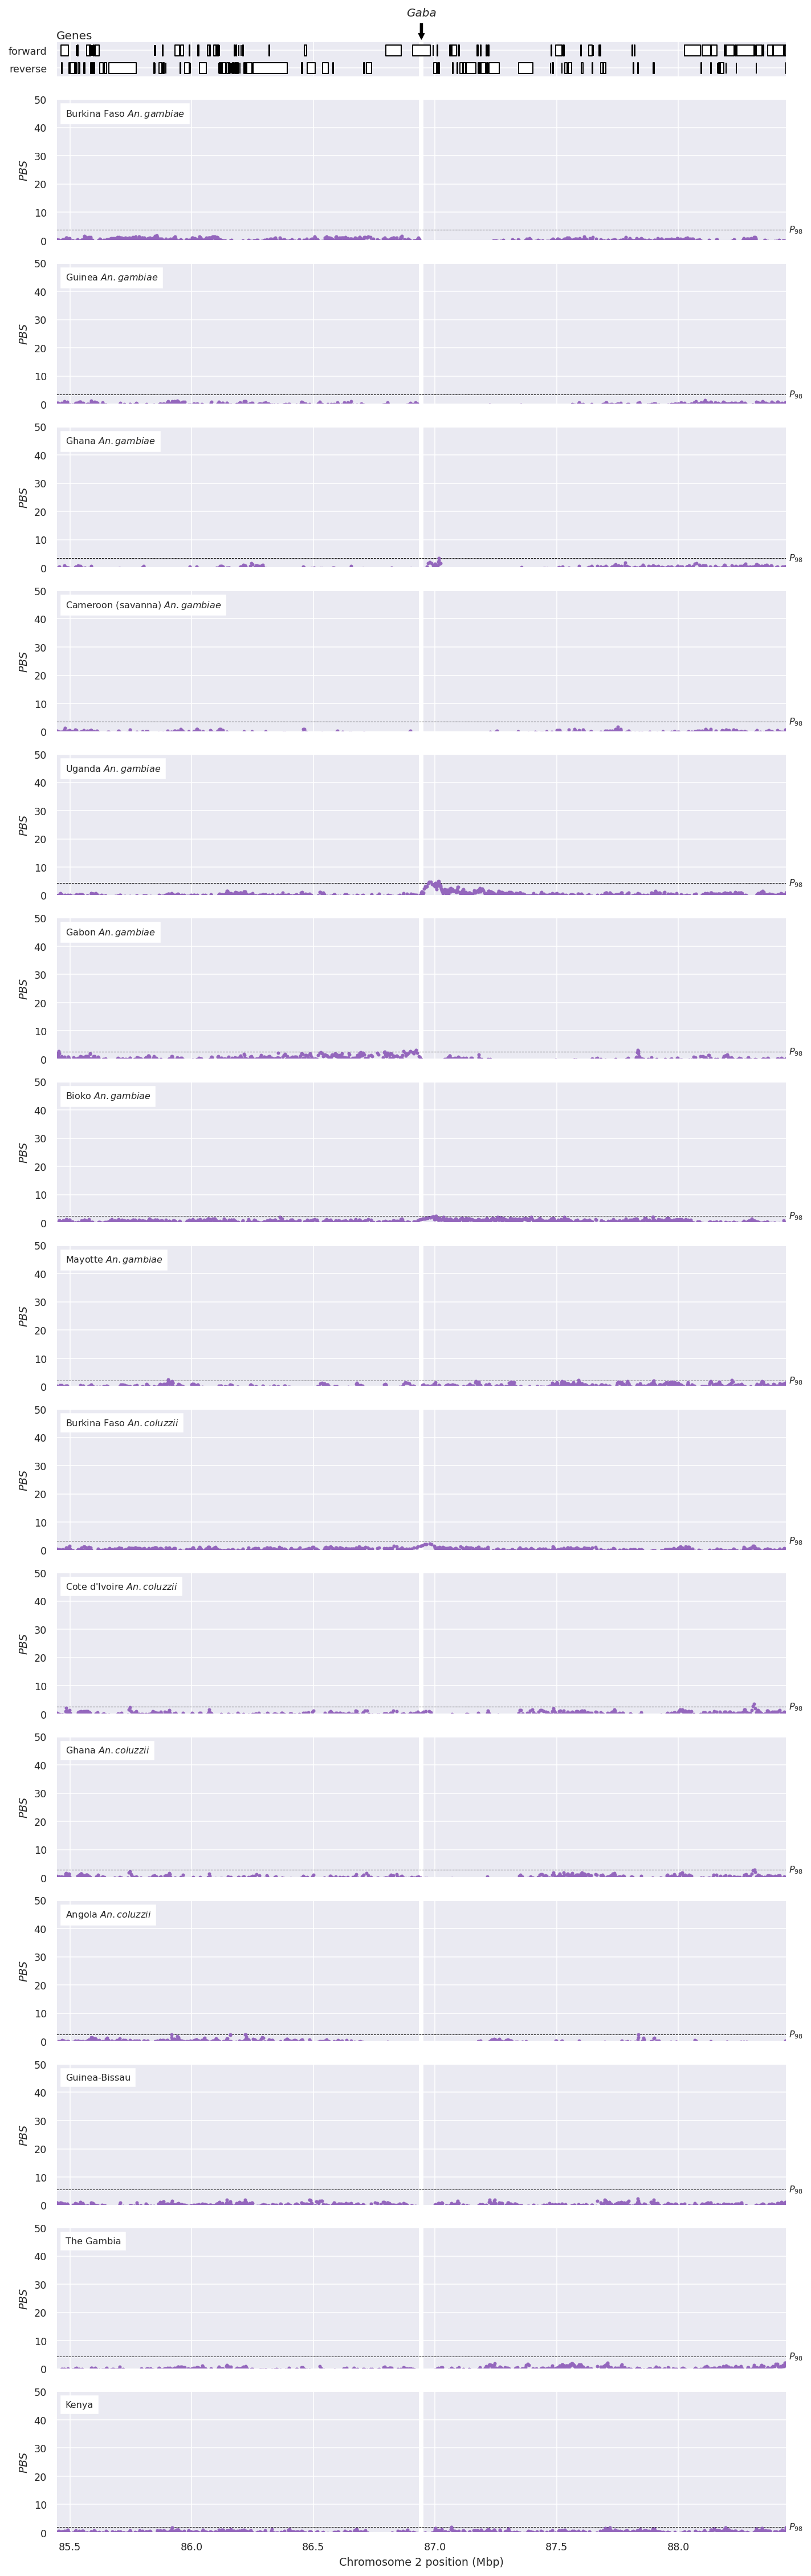

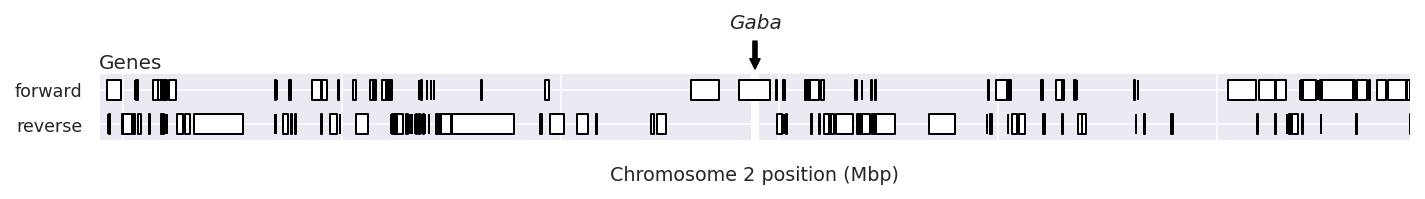

In [20]:
analyse_gene(gaba)

## *Ace1*

In [21]:
ace1

seqid                                                               2R
source                                                       VEuPathDB
type                                                              gene
start                                                          3483099
end                                                            3497400
score                                                               -1
strand                                                               +
phase                                                               -1
description          Acetylcholinesterase [Source:UniProtKB/Swiss-P...
chromosome                                                           2
chromosome_start                                               3483099
chromosome_end                                                 3497400
chromosome_center                                          3.49025e+06
Name                                                              Ace1
Name: 

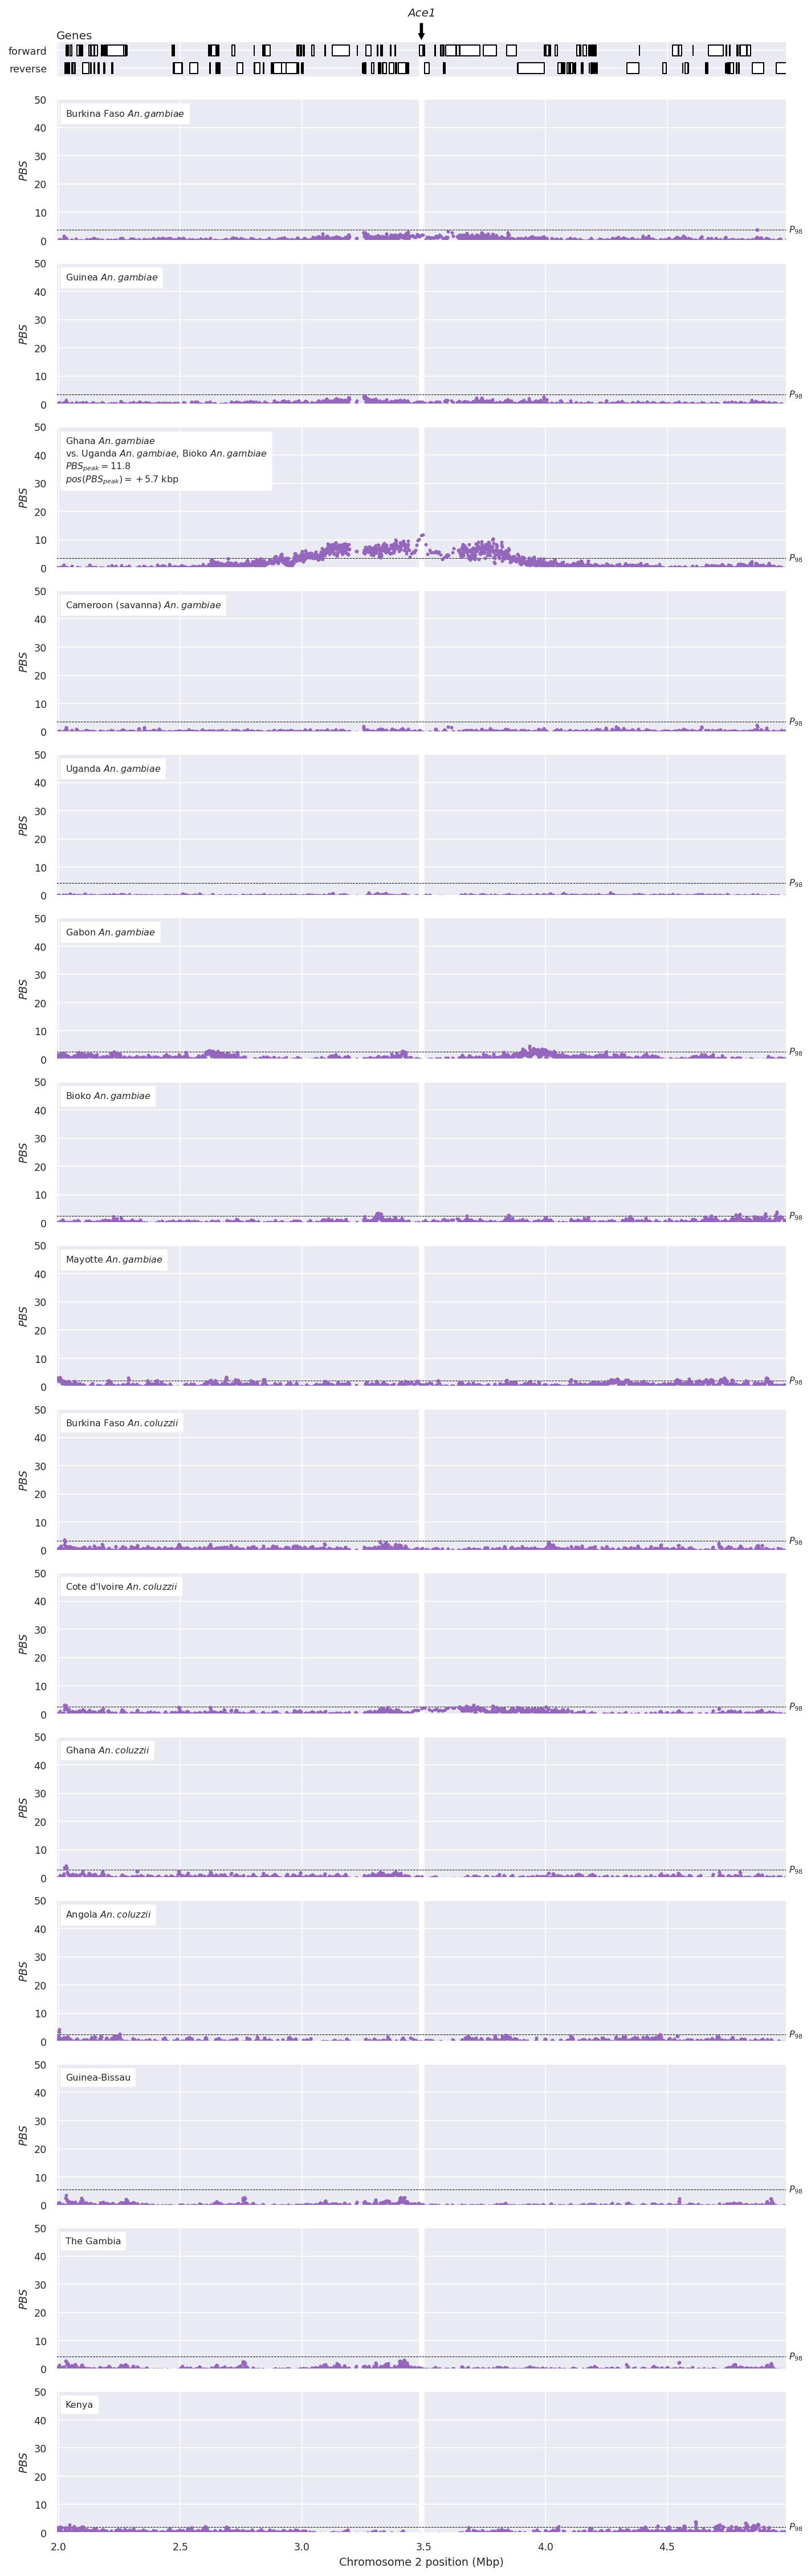

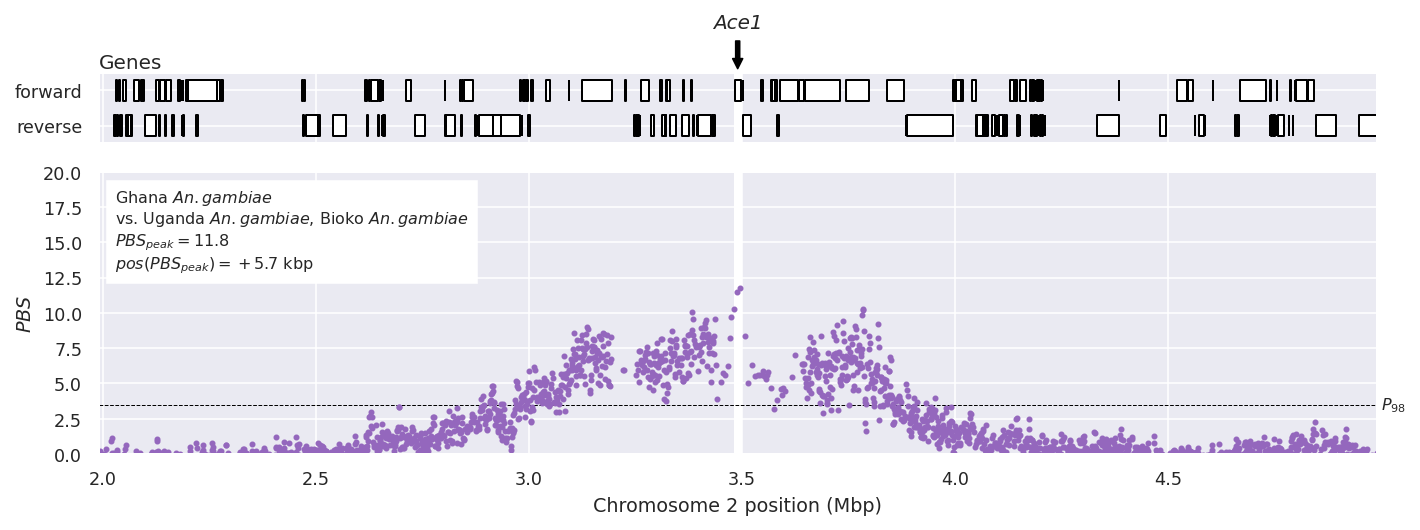

In [22]:
analyse_gene(ace1)

## Compile statistics

In [23]:
analyse_peak_stats(all_stats, slug='pbs', label='PBS')